<center>

# Treatment Diffusion and Spillover in Networked Experimental Design

### COMPSCI 590 Project

### Qinyang Yu and Weihang Liu

</center> 



In [19]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from collections import defaultdict
import random
from copy import deepcopy

## Simulation of Network Experiments with Bias & RMSE Comparison

### Generate network and Assign initial treatment 

Watts-Strogatz network: 1000 nodes, 5000 edges
Average degree: 10.00
Clustering coefficient: 0.1499
Random treatment rate: 37.70%
Clustered treatment rate: 38.50%
Number of clusters: 49
Average cluster size: 20.41


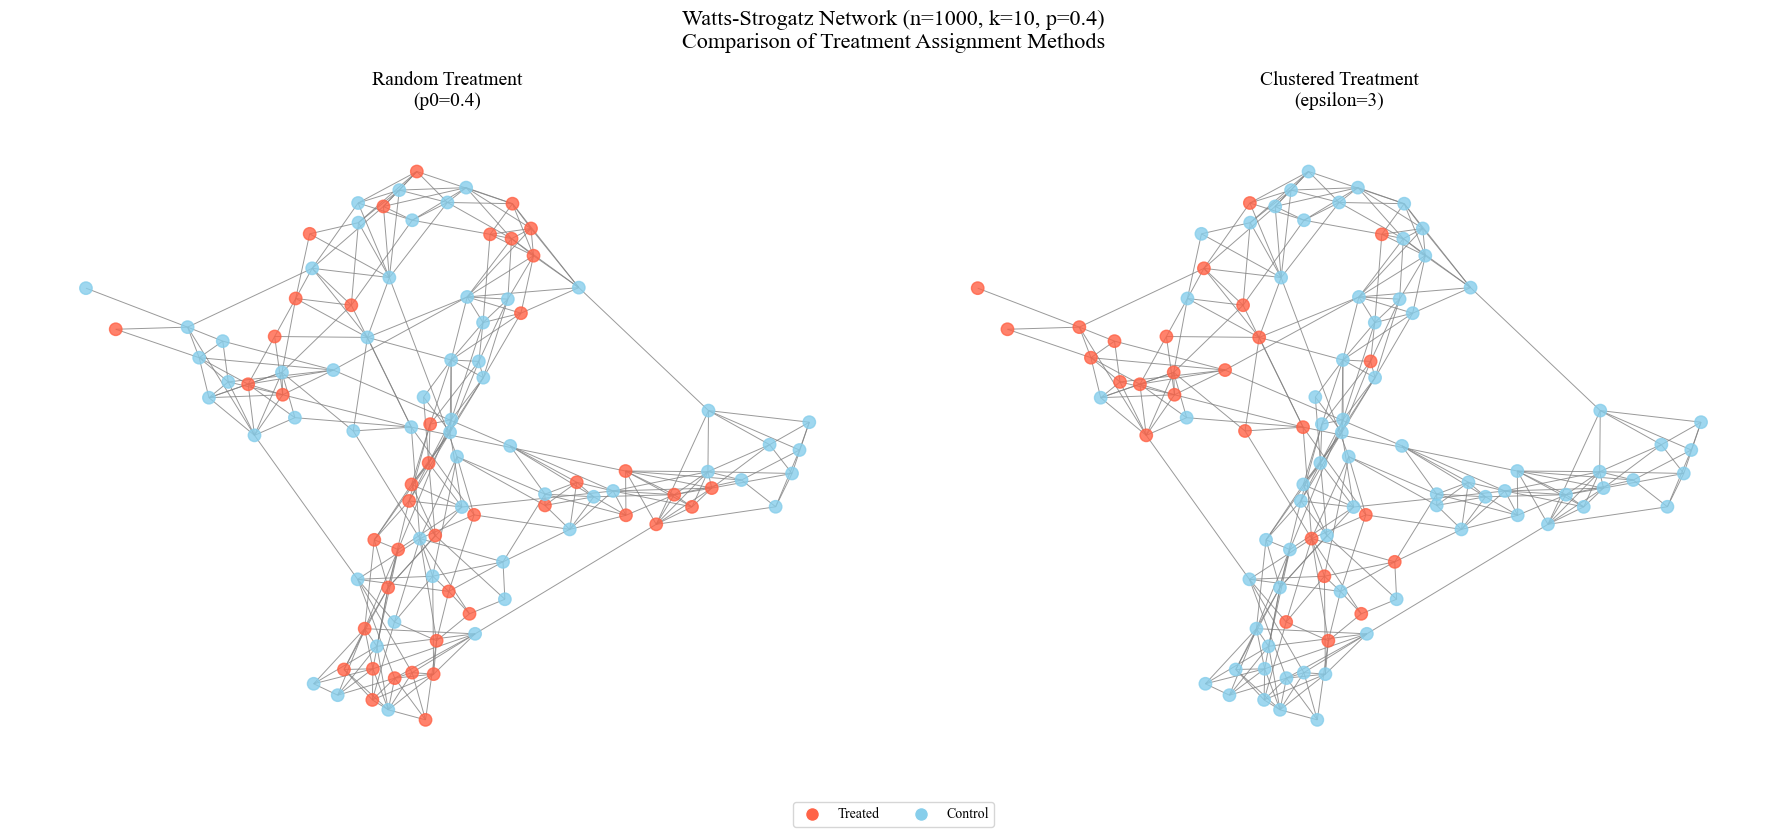

/var/folders/hb/tlt2t_zs2bdc10znvg6zp7vc0000gn/T/ipykernel_28703/3921405486.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


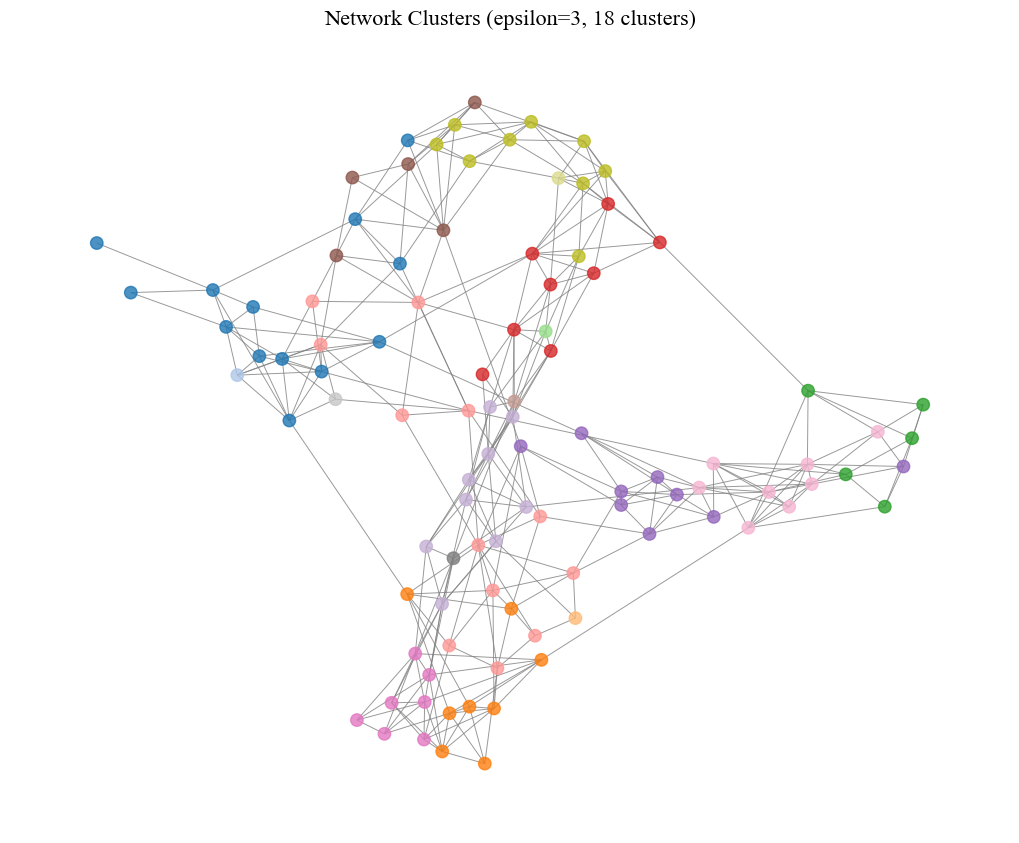

In [20]:
def epsilon_net_clustering(G, epsilon=3):
    uncovered = set(G.nodes())
    centers = []
    while uncovered:
        node = uncovered.pop()
        centers.append(node)
        for target, dist in nx.single_source_shortest_path_length(G, node, cutoff=epsilon-1).items():
            uncovered.discard(target)
    cluster_map = {}
    for n in G.nodes():
        closest = min(centers, key=lambda c: nx.shortest_path_length(G, n, c))
        cluster_map[n] = closest
    return cluster_map

def assign_clustered(G, clustering):
    cluster_vals = {c: random.choice([0, 1]) for c in set(clustering.values())}
    return {n: cluster_vals[clustering[n]] for n in G.nodes()}

def simulate_network_experiment(n=1000, k=10, p_rewire=0.4, p0=0.4, d=3, sample_size=100, use_clustering=False, epsilon=3):
    """
    Generate and visualize a Watts-Strogatz small-world network with initial treatment assignment
    
    Parameters:
    -----------
    n : Number of nodes in the network
    k : Each node is connected to k nearest neighbors in ring topology
    p_rewire : Probability of rewiring each edge
    p0 : Initial probability of treatment assignment
    d : Dimension of node feature vectors
    use_clustering : Whether to use cluster-based treatment assignment
    epsilon : The maximum distance parameter for epsilon-net clustering
    
    Returns:
    --------
    G : networkx.Graph
        The generated network with node attributes
    random_treatment : dict
        Dictionary mapping node IDs to random treatment status
    clustered_treatment : dict
        Dictionary mapping node IDs to clustered treatment status
    clustering : dict
        Dictionary mapping nodes to their cluster centers
    """
    
    # Set random seed for reproducibility once
    np.random.seed(77)
    random.seed(77)
    
    # 1. Generate Watts-Strogatz small-world network 
    G = nx.watts_strogatz_graph(n=n, k=k, p=p_rewire, seed=77)
    
    # 2. Generate node features X_i ~ N(0, I_d)
    for node in sorted(G.nodes()):  # Sort to ensure consistent order
        G.nodes[node]['features'] = np.random.multivariate_normal(np.zeros(d), np.eye(d))
    
    # 3. Assign initial treatment with both methods
    # 3a. Random treatment assignment Z_i(0) ~ Bernoulli(p0)
    random_treatment = {}
    for node in sorted(G.nodes()):  # Sort to ensure consistent order
        Z_0 = np.random.binomial(1, p0)
        G.nodes[node]['Z_0_random'] = Z_0
        random_treatment[node] = Z_0
    
    # 3b. Clustered treatment assignment
    clustering = epsilon_net_clustering(G, epsilon=epsilon)
    clustered_treatment = assign_clustered(G, clustering)
    
    # Store clustered treatment in node attributes
    for node in G.nodes():
        G.nodes[node]['Z_0_clustered'] = clustered_treatment[node]
        G.nodes[node]['cluster'] = clustering[node]
    
    # Count the number of clusters
    num_clusters = len(set(clustering.values()))
    
    # Print network statistics
    print(f"Watts-Strogatz network: {len(G.nodes())} nodes, {len(G.edges())} edges")
    print(f"Average degree: {np.mean([d for n, d in G.degree()]):.2f}")
    print(f"Clustering coefficient: {nx.average_clustering(G):.4f}")
    print(f"Random treatment rate: {sum(random_treatment.values())/n:.2%}")
    print(f"Clustered treatment rate: {sum(clustered_treatment.values())/n:.2%}")
    print(f"Number of clusters: {num_clusters}")
    
    # Calculate average cluster size
    cluster_sizes = defaultdict(int)
    for node, cluster in clustering.items():
        cluster_sizes[cluster] += 1
    avg_cluster_size = np.mean(list(cluster_sizes.values()))
    print(f"Average cluster size: {avg_cluster_size:.2f}")
    
    # Visualize small sample of the network if it's large
    if n > sample_size:
        # Take a deterministic sample for visualization
        sample_nodes = sorted(G.nodes())[:sample_size]  # Take first sample_size nodes
        G_sample = G.subgraph(sample_nodes)
        random_treatment_sample = {n: random_treatment[n] for n in sample_nodes}
        clustered_treatment_sample = {n: clustered_treatment[n] for n in sample_nodes}
        clustering_sample = {n: clustering[n] for n in sample_nodes}
    else:
        G_sample = G
        random_treatment_sample = random_treatment
        clustered_treatment_sample = clustered_treatment
        clustering_sample = clustering
    
    # Visualize both treatment assignments
    visualize_network(G_sample, random_treatment_sample, clustered_treatment_sample, 
                     clustering_sample, n, k, p_rewire, p0, epsilon)
    
    return G, random_treatment, clustered_treatment, clustering

def visualize_network(G, random_treatment, clustered_treatment, clustering, n, k, p_rewire, p0, epsilon):
    """Visualize the network with both treatment assignments"""
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Use same layout for both plots for comparison
    pos = nx.spring_layout(G, seed=77, iterations=100)
    
    # Prepare colors for random treatment
    node_list = sorted(G.nodes())  # Ensure consistent node order
    random_colors = ['skyblue' if random_treatment[n] == 0 else 'tomato' for n in node_list]
    
    # Plot for random treatment
    nx.draw(G, pos, ax=ax1,
            nodelist=node_list,
            node_color=random_colors,
            node_size=80,
            width=0.7,
            edge_color='gray',
            alpha=0.8)
    
    ax1.set_title(f"Random Treatment\n(p0={p0})", fontsize=14)
    
    # Prepare colors for clustered treatment
    clustered_colors = ['skyblue' if clustered_treatment[n] == 0 else 'tomato' for n in node_list]
    
    # Plot for clustered treatment
    nx.draw(G, pos, ax=ax2,
            nodelist=node_list,
            node_color=clustered_colors,
            node_size=80,
            width=0.7,
            edge_color='gray',
            alpha=0.8)
    
    ax2.set_title(f"Clustered Treatment\n(epsilon={epsilon})", fontsize=14)
    
    # Add legend
    treated = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label='Treated')
    control = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='Control')
    
    fig.legend(handles=[treated, control], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    
    # Main title
    fig.suptitle(f"Watts-Strogatz Network (n={n}, k={k}, p={p_rewire})\nComparison of Treatment Assignment Methods", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Visualization showing clusters
    plt.figure(figsize=(10, 8))
    
    # Assign a unique color to each cluster for visualization
    clusters = set(clustering.values())
    cluster_colors = {c: plt.cm.tab20(i % 20) for i, c in enumerate(clusters)}
    
    # Color nodes by their cluster
    node_colors = [cluster_colors[clustering[n]] for n in node_list]
    
    # Draw the network with cluster coloring
    nx.draw(G, pos,
            nodelist=node_list,
            node_color=node_colors,
            node_size=80,
            width=0.7,
            edge_color='gray',
            alpha=0.8)
    
    plt.title(f"Network Clusters (epsilon={epsilon}, {len(clusters)} clusters)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the simulation
if __name__ == "__main__":
    G, random_treatment, clustered_treatment, clustering = simulate_network_experiment(
        n=1000,         # Number of nodes
        k=10,           # Each node connected to k nearest neighbors
        p_rewire=0.4,   # Rewiring probability 
        p0=0.4,         # Initial treatment probability
        d=3,            # Dimension of covariates
        sample_size=100, # Sample size for visualization
        use_clustering=True,  # Enable clustered treatment
        epsilon=3       # Epsilon parameter for clustering
    )

###  Diffusion process

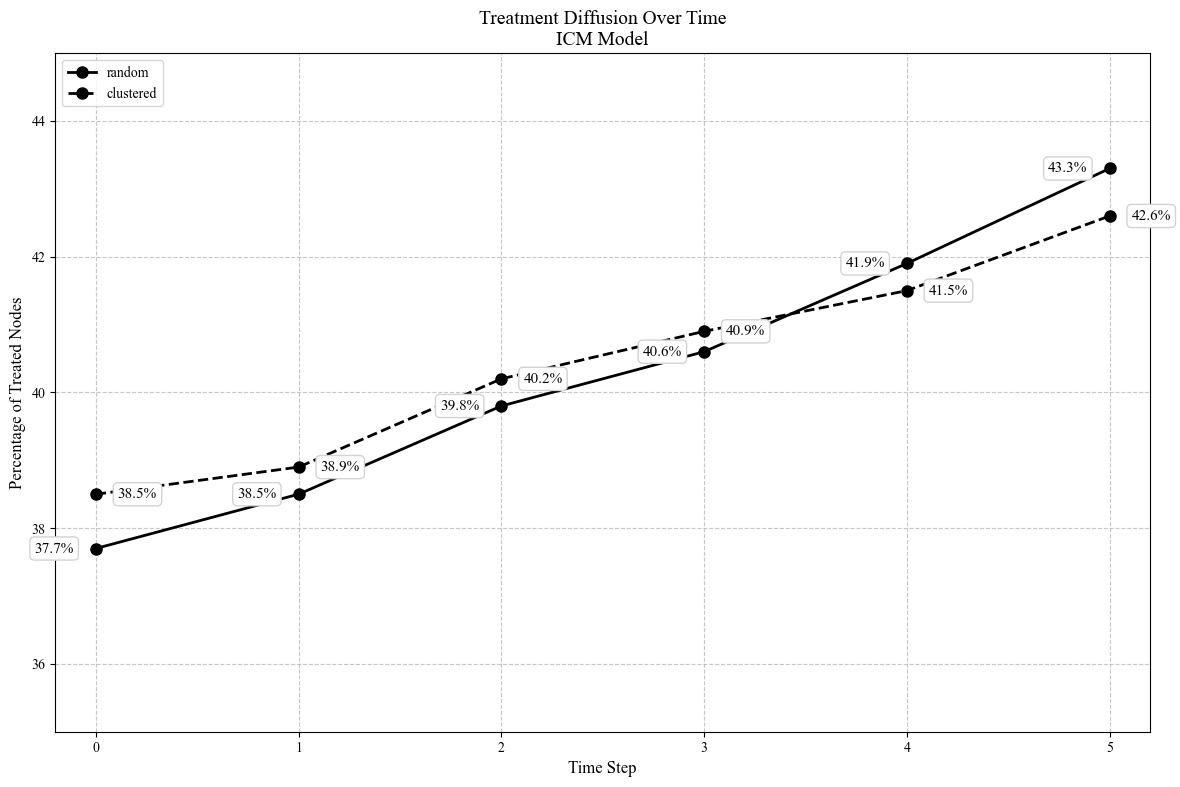

In [21]:
def simulate_treatment_diffusion(G, initial_treatment, T=5, diffusion_model='ICM', p=0.01):
    """
    Simulate treatment diffusion over time steps for one initial treatment assignment.
    """

    np.random.seed(88)

    treatment_history = {0: initial_treatment.copy()}

    # Copy initial treatment to graph
    for node, z in initial_treatment.items():
        G.nodes[node]['Z_0'] = z
    # Initialize ICM or LTM parameters on G
    if diffusion_model == 'ICM':
        for u, v in G.edges():
            G[u][v]['p_activate'] = np.random.uniform(0, p)
            G[v][u]['p_activate'] = G[u][v]['p_activate']
    elif diffusion_model == 'LTM':
        for node in G.nodes():
            G.nodes[node]['threshold'] = np.random.uniform(0, 1)
        for u, v in G.edges():
            weight_uv = 1 / G.degree(v) if G.degree(v) > 0 else 0
            weight_vu = 1 / G.degree(u) if G.degree(u) > 0 else 0
            G[u][v]['weight'] = weight_uv
            G[v][u]['weight'] = weight_vu

    # Run diffusion
    for t in range(1, T + 1):
        prev = treatment_history[t - 1]
        curr = prev.copy()

        if diffusion_model == 'ICM':
            for node in G.nodes():
                if prev[node] == 1:
                    continue
                # compute non-activation prob
                non_act_prob = 1.0
                for nbr in G.neighbors(node):
                    if prev[nbr] == 1:
                        non_act_prob *= (1 - G[nbr][node]['p_activate'])
                act_prob = 1 - non_act_prob
                if np.random.rand() < act_prob:
                    curr[node] = 1
        else:  # LTM
            for node in G.nodes():
                if prev[node] == 1:
                    continue
                total_infl = sum(G[nbr][node]['weight'] for nbr in G.neighbors(node) if prev[nbr] == 1)
                if total_infl >= G.nodes[node]['threshold']:
                    curr[node] = 1

        treatment_history[t] = curr
        for node, z in curr.items():
            G.nodes[node][f'Z_{t}'] = z

    return treatment_history


def simulate_multiple_diffusions(G, initial_treatments, T=5, diffusion_model='ICM', p=0.01):
    """
    Simulate diffusion for multiple initial assignments.
    Parameters:
      initial_treatments: dict of name -> {node: status}
    Returns:
      dict of name -> treatment_history
    """
    
    np.random.seed(88)

    histories = {}
    for name, init in initial_treatments.items():
        G_copy = deepcopy(G)
        histories[name] = simulate_treatment_diffusion(G_copy, init, T, diffusion_model, p)
    return histories

def visualize_diffusion_comparison(histories, diffusion_model, p):
    """ Plot percentage of treated nodes over time for multiple assignments. """
    plt.figure(figsize=(12, 8))
    
    # Define line styles
    styles = [
        {'linestyle': '-', 'marker': 'o', 'x_offset': -30, 'y_offset': 0},  # First line - labels upper left
        {'linestyle': '--', 'marker': 'o', 'x_offset': 30, 'y_offset': 0}  # Second line - labels lower right
    ]
    
    for i, (name, hist) in enumerate(histories.items()):
        style = styles[i % len(styles)]
        times = sorted(hist.keys())
        frac = [sum(hist[t].values()) / len(hist[t]) * 100 for t in times]
        
        # Plot the line with markers
        line = plt.plot(times, frac, marker=style['marker'], linestyle=style['linestyle'], 
                    color='black', label=name, linewidth=2, markersize=8)
        
        # Add percentage labels with specified positioning
        for x, y in zip(times, frac):
            plt.annotate(f'{y:.1f}%', (x, y), 
                         xytext=(style['x_offset'], style['y_offset']), 
                         textcoords='offset points',
                         ha='center', va='center',
                         bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray'))
    
    # Customize the plot
    plt.xlabel('Time Step')
    plt.ylabel('Percentage of Treated Nodes')
    plt.title(f'Treatment Diffusion Over Time\n{diffusion_model} Model')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Focus on the area of interest - adjust as needed
    plt.ylim(35, 45)  # Example range based on your image
    
    # Full x-axis range with padding
    plt.xlim(-0.2, max(times) + 0.2)
    
    # Add legend at top left
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    np.random.seed(88)

    T = 5
    diffusion_model = 'ICM'
    p = 0.01

    initial_treatments = {
        'random': random_treatment,
        'clustered': clustered_treatment
    }

    histories = simulate_multiple_diffusions(G, initial_treatments, T, diffusion_model, p)
    visualize_diffusion_comparison(histories, diffusion_model, p)

### Outcome Simulation

In [22]:
def simulate_outcomes_probit(G,
                             treatment_history,
                             beta,
                             gamma,
                             T=5,
                             alpha=-1.5,
                             sigma=1.0):
    """
    Simulate period-by-period outcome probabilities under a probit link,
    then optionally draw a binary Yi ~ Bernoulli(prob).
    """
    # initialize (probabilities) at t=0
    Yi = {n: 0.0 for n in G.nodes()}
    
    for t in range(1, T+1):
        # Get cumulative treatment at time t
        Zt = treatment_history[t]
        new_Yi = {}
        
        for i in G.nodes():
            # Cumulative treatment for individual i
            zi = Zt[i]
            # Get neighbors
            nbrs = list(G.neighbors(i))
            # Calculate average cumulative treatment of neighbors
            peer_mean = np.mean([Yi[j] for j in nbrs]) if nbrs else 0.0
            # Generate random error term
            epsilon = np.random.normal(0, sigma)

            # Linear predictor following the mathematical model
            linpred = alpha + beta * zi + gamma * peer_mean + epsilon
            # Binary outcome: Y_i(t) = 1{Y_i(t)^* > 0}
            new_Yi[i] = 1 if linpred > 0 else 0
        Yi = new_Yi
    
    return Yi

def individual_unweighted(Y, Z):
    Y1 = [Y[n] for n in Y if Z[n]==1]
    Y0 = [Y[n] for n in Y if Z[n]==0]
    return np.mean(Y1)-np.mean(Y0)

def neighborhood_unweighted(Y, Z, G, lambda_=0.75):
    keep = []
    for i in G.nodes():
        neigh = list(G.neighbors(i))
        if not neigh: continue
        frac_same = np.mean([1 if Z[j]==Z[i] else 0 for j in neigh])
        if frac_same>=lambda_:
            keep.append(i)
    if not keep: return np.nan
    Y1 = [Y[i] for i in keep if Z[i]==1]
    Y0 = [Y[i] for i in keep if Z[i]==0]
    return np.mean(Y1)-np.mean(Y0)

def neighborhood_hajek(Y, Z, G, lambda_=0.75, histories=None):
    """
    Implements the Hajek estimator for average treatment effects under interference.
    
    Parameters:
    Y: Dictionary of outcomes for each node
    Z: Dictionary of treatment assignments for each node
    G: NetworkX graph
    lambda_: Threshold for neighborhood treatment status
    histories: Output from simulate_multiple_diffusions
    """
    # Calculate propensity scores
    all_assignments = []
    
    # Process histories from simulate_multiple_diffusions function
    if histories is not None:
        for name in histories:
            history = histories[name]
            for t in history:
                all_assignments.append(history[t])
    
    total_assignments = len(all_assignments) if all_assignments else 1
    exposure_d1_counts = {i: 0 for i in G.nodes()}
    exposure_d0_counts = {i: 0 for i in G.nodes()}
    
    # Count exposures across all assignments
    for assignment in all_assignments:
        for i in G.nodes():
            neighbors = list(G.neighbors(i))
            if not neighbors:
                continue
                
            n_neigh = len(neighbors)
            n_treated_neigh = sum(1 for j in neighbors if assignment[j] == 1)
            frac_treated = n_treated_neigh / n_neigh
            frac_control = 1 - frac_treated
            
            if assignment[i] == 1 and frac_treated >= lambda_:
                exposure_d1_counts[i] += 1
            elif assignment[i] == 0 and frac_control >= lambda_:
                exposure_d0_counts[i] += 1
    
    # Calculate propensity scores with a minimum value
    pi_d1 = {i: max(count/total_assignments, 0.001) for i, count in exposure_d1_counts.items()}
    pi_d0 = {i: max(count/total_assignments, 0.001) for i, count in exposure_d0_counts.items()}
    
    # Identify nodes in each exposure condition under current assignment Z
    d_1_nodes = []
    d_0_nodes = []
    
    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        if not neighbors:
            continue
            
        n_neigh = len(neighbors)
        n_treated_neigh = sum(1 for j in neighbors if Z[j] == 1)
        frac_treated = n_treated_neigh / n_neigh
        frac_control = 1 - frac_treated
        
        if Z[i] == 1 and frac_treated >= lambda_:
            d_1_nodes.append(i)
        elif Z[i] == 0 and frac_control >= lambda_:
            d_0_nodes.append(i)
    
    # Return NaN if either group is empty
    if not d_1_nodes or not d_0_nodes:
        return np.nan
    
    # Hajek estimator for each condition
    sum_y1 = sum(Y[i] / pi_d1[i] for i in d_1_nodes)
    sum_w1 = sum(1 / pi_d1[i] for i in d_1_nodes)
    sum_y0 = sum(Y[i] / pi_d0[i] for i in d_0_nodes)
    sum_w0 = sum(1 / pi_d0[i] for i in d_0_nodes)
    
    # Calculate the ATE
    mu_hat_1 = sum_y1 / sum_w1 if sum_w1 > 0 else 0
    mu_hat_0 = sum_y0 / sum_w0 if sum_w0 > 0 else 0
    
    return mu_hat_1 - mu_hat_0

### True ATE Estimation
Compute the “ground truth” ATE by simulating under **all‑treatment** vs **all‑control** assignments.

In [24]:
def run_simulation(G, histories, beta, gamma, reps=100, T=5, alpha=-1.5):
    """
    Run multiple simulation replications to compute all ATE estimators.
    
    Parameters:
    -----------
    G : networkx.Graph
        The network graph
    histories : dict
        Dictionary mapping treatment assignment type to treatment history
    beta : float
        Direct effect of treatment
    gamma : float
        Peer effect strength
    reps : int
        Number of simulation replications
    T : int
        Number of time steps
    alpha : float
        Baseline parameter (threshold)
        
    Returns:
    --------
    results : dict
        Dictionary with all estimator results organized by timepoint and replicate
    """
    np.random.seed(99)
    
    # Dictionary to store all results
    results = {
        "true_ate": [], 
        "indiv_rand": [], "indiv_clust": [],
        "neigh_rand": [], "neigh_clust": [],
        "hajek_rand": [], "hajek_clust": []
    }
    
    # Get treatment assignment histories for both random and clustered
    random_history = histories['random']
    clustered_history = histories['clustered']
    
    # Simulate global treatment and control for true ATE
    print(f"Simulating true ATE with beta={beta}, gamma={gamma}...")
    
    # Create copies of G for all-treatment and all-control
    G_all_treat = G.copy()
    G_all_control = G.copy()
    
    # Set up global treatment assignment dictionaries
    all_treat = {n: 1 for n in G.nodes()}
    all_control = {n: 0 for n in G.nodes()}
    
    # For true ATE computation
    true_ate_vals = []
    
    for rep in range(reps):
        if rep % 100 == 0:
            print(f"Starting replication {rep}...")
        
        # Run outcomes for global treatment and control
        treat_history = {t: all_treat for t in range(T+1)}
        control_history = {t: all_control for t in range(T+1)}
        
        Y_treat = simulate_outcomes_probit(G_all_treat, treat_history, beta, gamma, T, alpha)
        Y_control = simulate_outcomes_probit(G_all_control, control_history, beta, gamma, T, alpha)
        
        # Compute true ATE
        treat_mean = np.mean(list(Y_treat.values()))
        control_mean = np.mean(list(Y_control.values()))
        true_ate = treat_mean - control_mean
        true_ate_vals.append(true_ate)
        
        # For each time point, compute all estimators for both assignments
        for t in range(1, T+1):
            # Get treatment assignments at time t
            Z_rand = random_history[t]
            Z_clust = clustered_history[t]
            
            # Simulate outcomes for both assignment methods
            Y_rand = simulate_outcomes_probit(G.copy(), random_history, beta, gamma, t, alpha)
            Y_clust = simulate_outcomes_probit(G.copy(), clustered_history, beta, gamma, t, alpha)
            
            # Individual unweighted estimator (difference in means)
            indiv_rand = individual_unweighted(Y_rand, Z_rand)
            indiv_clust = individual_unweighted(Y_clust, Z_clust)
            
            # Neighborhood unweighted estimator
            neigh_rand = neighborhood_unweighted(Y_rand, Z_rand, G)
            neigh_clust = neighborhood_unweighted(Y_clust, Z_clust, G)
            
            # Neighborhood Hajek estimator
            hajek_rand = neighborhood_hajek(Y_rand, Z_rand, G)
            hajek_clust = neighborhood_hajek(Y_clust, Z_clust, G)
            
            # Store all results with timestep and rep information
            results.setdefault(f"indiv_rand_t{t}", []).append(indiv_rand)
            results.setdefault(f"indiv_clust_t{t}", []).append(indiv_clust)
            results.setdefault(f"neigh_rand_t{t}", []).append(neigh_rand)
            results.setdefault(f"neigh_clust_t{t}", []).append(neigh_clust)
            results.setdefault(f"hajek_rand_t{t}", []).append(hajek_rand)
            results.setdefault(f"hajek_clust_t{t}", []).append(hajek_clust)
    
    # Store true ATE values
    results["true_ate"] = true_ate_vals
    
    # Compute bias and RMSE statistics
    print("Computing summary statistics...")
    summary = compute_summary_statistics(results, T)
    
    return results, summary

def compute_summary_statistics(results, T):
    """
    Compute bias and RMSE for all estimators.
    """
    summary = {}
    true_ate = np.nanmean(results["true_ate"])
    
    # For each time point
    for t in range(1, T+1):
        # For each estimator
        for estimator in ["indiv", "neigh", "hajek"]:
            # For each assignment
            for assign in ["rand", "clust"]:
                key = f"{estimator}_{assign}_t{t}"
                if key in results:
                    # Filter out NaN values
                    vals = np.array([x for x in results[key] if not np.isnan(x)])
                    if len(vals) > 0:
                        bias = np.mean(vals) - true_ate
                        rmse = np.sqrt(np.mean((vals - true_ate)**2))
                        summary[f"{key}_bias"] = bias
                        summary[f"{key}_rmse"] = rmse
                        summary[f"{key}_mean"] = np.mean(vals)
                        summary[f"{key}_median"] = np.median(vals)
                        summary[f"{key}_std"] = np.std(vals)
                        summary[f"{key}_count"] = len(vals)
    
    return summary

### Bias & RMSE Comparison
Run the main simulation and compute bias/RMSE for each estimator.

In [ ]:
results, summary = run_simulation(
    G=G,
    histories=histories,
    beta=0.5,     # override default if needed
    gamma=0.5     # override default if needed
    # Using default values for reps=500, T=5, alpha=-1.5
)

# Display summary of results
print("\nSimulation Summary:")
print("-------------------")
print(f"True ATE (average): {np.nanmean(results['true_ate']):.4f}")

# Print bias for each estimator
print("\nBias:")
for t in range(1, T):
    print(f"\nTime step {t}:")
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            key = f"{estimator}_{assign}_t{t}_bias"
            if key in summary:
                print(f"  {estimator}_{assign}: {summary[key]:.4f}")

# Print RMSE for each estimator
print("\nRMSE:")
for t in range(1, T):
    print(f"\nTime step {t}:")
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            key = f"{estimator}_{assign}_t{t}_rmse"
            if key in summary:
                print(f"  {estimator}_{assign}: {summary[key]:.4f}")

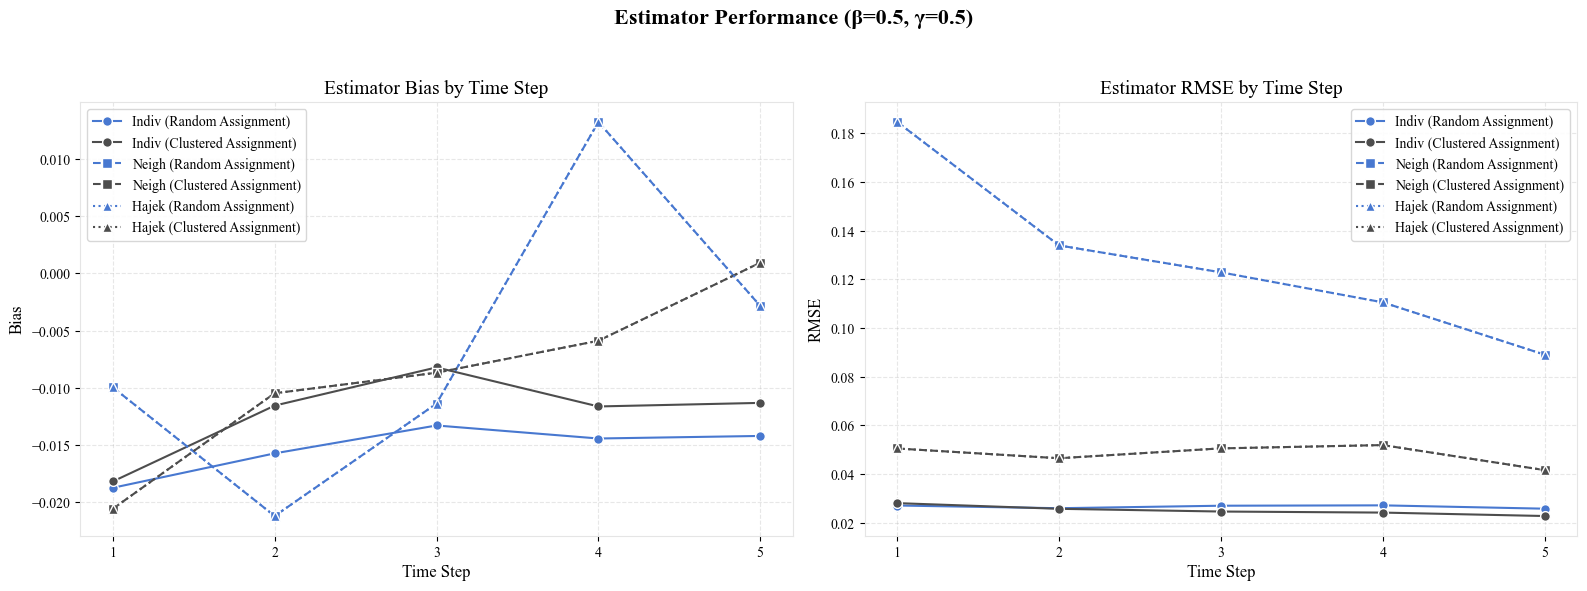

In [ ]:
def visualize_simulation_results(summary, T=5):
    """
    Visualize bias and RMSE results from the simulation with academic styling.
    
    Parameters:
    -----------
    summary : dict
        Dictionary with summary statistics
    T : int
        Number of time steps
    """
    # Setup plot style for academic look
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'Computer Modern Roman'],
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
    })
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
    
    # Academic color palette - muted blues and grays
    colors = {
        'rand': '#4878D0',    # Medium blue for random assignment
        'clust': '#4D4D4D'    # Dark gray for clustered assignment
    }
    
    # Academic marker styles
    styles = {
        'indiv': {'linestyle': '-', 'marker': 'o', 'markersize': 7, 'linewidth': 1.5, 'markeredgewidth': 1, 'markeredgecolor': 'white'},
        'neigh': {'linestyle': '--', 'marker': 's', 'markersize': 7, 'linewidth': 1.5, 'markeredgewidth': 1, 'markeredgecolor': 'white'},
        'hajek': {'linestyle': ':', 'marker': '^', 'markersize': 7, 'linewidth': 1.5, 'markeredgewidth': 1, 'markeredgecolor': 'white'}
    }
    
    # Setup labels for assignment methods
    assign_labels = {
        'rand': 'Independent Assignment',
        'clust': 'Clustered Assignment'
    }
    
    # Time steps for x-axis
    time_steps = list(range(1, T+1))
    
    # Plot bias
    for estimator, style in styles.items():
        for assign, color in colors.items():
            # Get bias values across time steps
            bias_values = []
            for t in time_steps:
                key = f"{estimator}_{assign}_t{t}_bias"
                if key in summary:
                    bias_values.append(summary[key])
                else:
                    bias_values.append(float('nan'))
                
            # Plot line with academic style and color
            label = f"{estimator.capitalize()} ({assign_labels[assign]})"
            ax1.plot(time_steps, bias_values, color=color, label=label, **style)
    
    # Plot RMSE
    for estimator, style in styles.items():
        for assign, color in colors.items():
            # Get RMSE values across time steps
            rmse_values = []
            for t in time_steps:
                key = f"{estimator}_{assign}_t{t}_rmse"
                if key in summary:
                    rmse_values.append(summary[key])
                else:
                    rmse_values.append(float('nan'))
                
            # Plot line with academic style and color
            label = f"{estimator.capitalize()} ({assign_labels[assign]})"
            ax2.plot(time_steps, rmse_values, color=color, label=label, **style)
    
    # Set titles and labels with serif font
    ax1.set_title('Estimator Bias by Time Step', fontsize=14)
    ax1.set_xlabel('Time Step', fontsize=12)
    ax1.set_ylabel('Bias', fontsize=12)
    
    ax2.set_title('Estimator RMSE by Time Step', fontsize=14)
    ax2.set_xlabel('Time Step', fontsize=12)
    ax2.set_ylabel('RMSE', fontsize=12)
    
    # Add a main title with parameter values
    beta_val = summary.get('beta', 0.5)
    gamma_val = summary.get('gamma', 0.5)
    fig.suptitle(f'Estimator Performance (β={beta_val}, γ={gamma_val})', fontsize=16, fontweight='bold')
    
    # Add legend with cleaner styling
    ax1.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='lightgray')
    ax2.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='lightgray')
    
    # Adjust x-axis ticks
    ax1.set_xticks(time_steps)
    ax2.set_xticks(time_steps)
    
    # Add light gray box around plots
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_color('#E5E5E5')
        ax.spines['right'].set_color('#E5E5E5')
        ax.spines['bottom'].set_color('#E5E5E5')
        ax.spines['left'].set_color('#E5E5E5')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    
    # Return the figure for potential saving
    return fig

# After running the simulation and getting results:
# Store beta and gamma in the summary for the plot title
summary['beta'] = 0.5
summary['gamma'] = 0.5

# Create the visualization
fig = visualize_simulation_results(summary, T=5)

# Save the figure
fig.savefig('simulation_results.png', dpi=300, bbox_inches='tight')


Running simulation for beta=0.1, gamma=0.1
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.5, gamma=0.1
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.9, gamma=0.1
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...


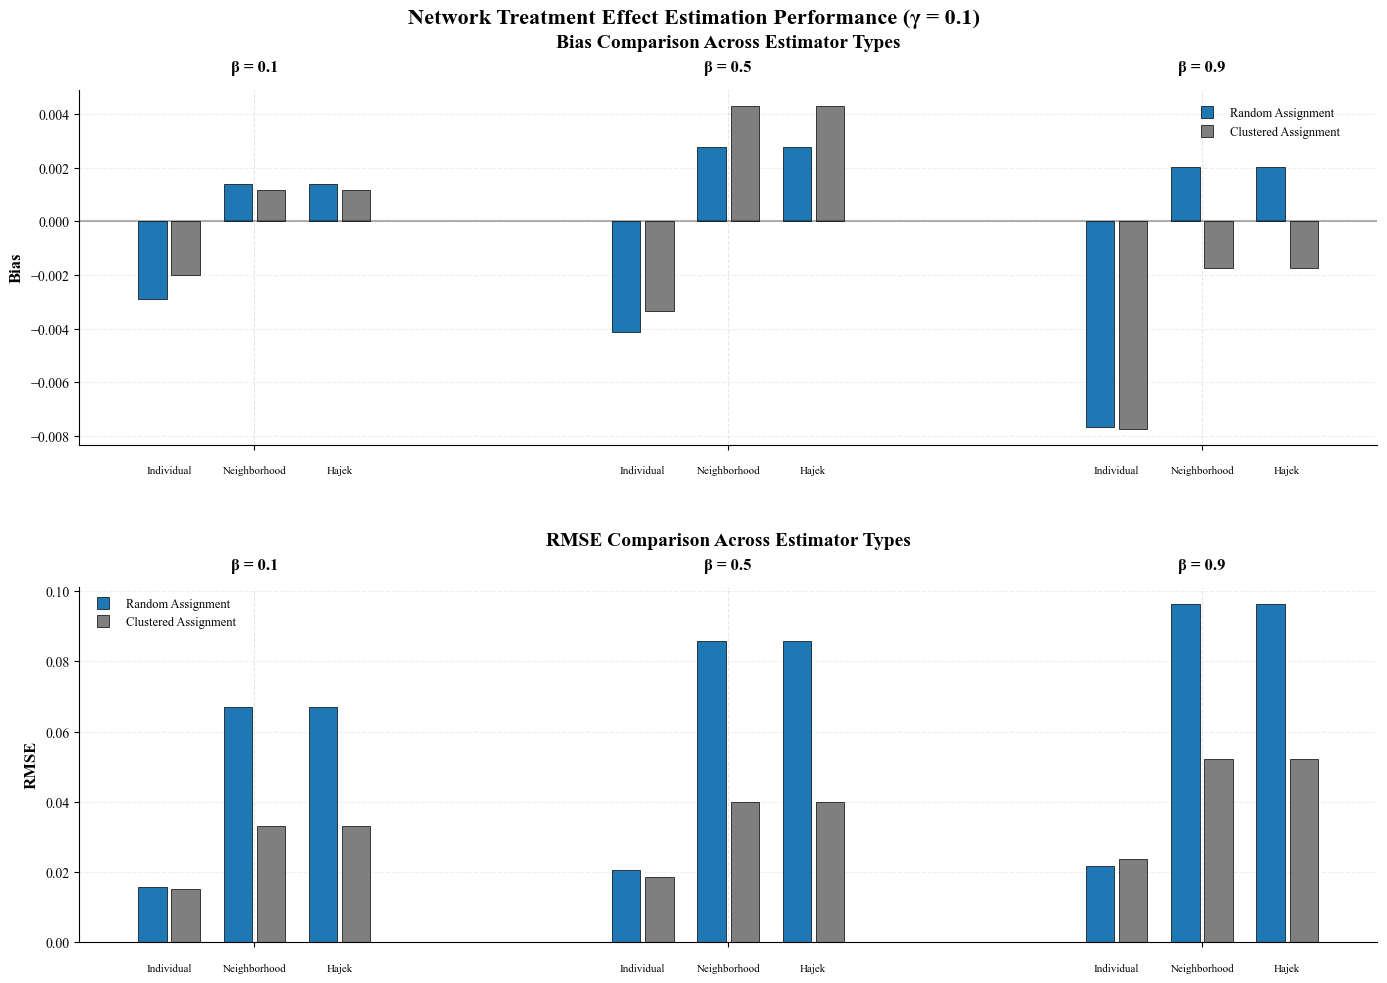

In [24]:
# Run simulations for multiple beta values (0.1, 0.5, 0.9) with gamma=0.1
beta_values = [0.1, 0.5, 0.9]
gamma_value = 0.1
T = 5
reps = 100  # Reduced for faster execution

# Store results and summaries
all_results = {}
all_summaries = {}

# Run simulations for each beta value
for beta in beta_values:
    print(f"\nRunning simulation for beta={beta}, gamma={gamma_value}")
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma_value,
        T=T,
        reps=reps
    )
    all_results[beta] = results
    all_summaries[beta] = summary

# Create plots - one for bias and one for RMSE
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Define estimators, labels, and colors
estimators = ['indiv', 'neigh', 'hajek']
est_labels = ['Individual', 'Neighborhood', 'Hajek']
assigns = ['rand', 'clust']
assign_labels = ['Random Assignment', 'Clustered Assignment']
colors = ['#1f77b4', '#7f7f7f']  # Professional blue/gray colors

# Adjust these parameters for better appearance
bar_width = 0.06  # Width of individual bars
bar_spacing = 0.01  # Space between adjacent bars (random vs clustered)
group_spacing = 0.06  # Space between estimator groups (indiv/neigh/hajek)
beta_spacing = 0.5  # Space between beta groups

# Calculate group positions centered on x ticks
x = np.arange(len(beta_values))
all_positions = []
group_centers = {}  # To store centers of each beta-estimator group for labels

for i, beta in enumerate(beta_values):
    for j, est in enumerate(estimators):
        # Calculate center position for this estimator within this beta group
        center_pos = x[i] + (j - 1) * (2*bar_width + group_spacing)
        group_centers[(beta, est)] = center_pos
        
        # Position for random assignment bar
        rand_pos = center_pos - bar_width/2 - bar_spacing/2
        all_positions.append((rand_pos, est, 'rand', beta))
        
        # Position for clustered assignment bar
        clust_pos = center_pos + bar_width/2 + bar_spacing/2
        all_positions.append((clust_pos, est, 'clust', beta))

# Prepare data for plotting
bias_data = []
rmse_data = []
x_pos_bias = []
x_pos_rmse = []
bar_colors = []

for pos, est, assign, beta in all_positions:
    summary = all_summaries[beta]
    bias_key = f"{est}_{assign}_t{T}_bias"
    rmse_key = f"{est}_{assign}_t{T}_rmse"
    
    # Choose color based on assignment type
    color = colors[0] if assign == 'rand' else colors[1]
    bar_colors.append(color)
    
    if bias_key in summary:
        bias_data.append(summary[bias_key])
        x_pos_bias.append(pos)
    
    if rmse_key in summary:
        rmse_data.append(summary[rmse_key])
        x_pos_rmse.append(pos)

# Plot bias (top plot)
ax = axes[0]

# Create bars for bias
bars_bias = ax.bar(x_pos_bias, bias_data, bar_width, color=bar_colors, 
                   edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('Bias', fontsize=12, fontweight='bold')
ax.set_title('Bias Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Add a zero line
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Create a custom legend and position it in the top right but shifted away from the plot edge
legend_elements = [
    Line2D([0], [0], color=colors[0], lw=0, marker='s', markersize=8, 
           label=assign_labels[0], markeredgecolor='black', markeredgewidth=0.5),
    Line2D([0], [0], color=colors[1], lw=0, marker='s', markersize=8, 
           label=assign_labels[1], markeredgecolor='black', markeredgewidth=0.5)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, frameon=False, 
         bbox_to_anchor=(0.98, 0.98))

# Plot RMSE (bottom plot)
ax = axes[1]

# Create bars for RMSE
bars_rmse = ax.bar(x_pos_rmse, rmse_data, bar_width, color=bar_colors, 
                    edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Add legend - moved to the left side to avoid overlap with data
ax.legend(handles=legend_elements, loc='upper left', fontsize=9, frameon=False)

# Overall title with more space
plt.suptitle(f'Network Treatment Effect Estimation Performance (γ = {gamma_value})', 
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout with more space between plots and top title
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.4)
plt.show()


Running simulation for beta=0.1, gamma=0.5
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.5, gamma=0.5
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.9, gamma=0.5
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...


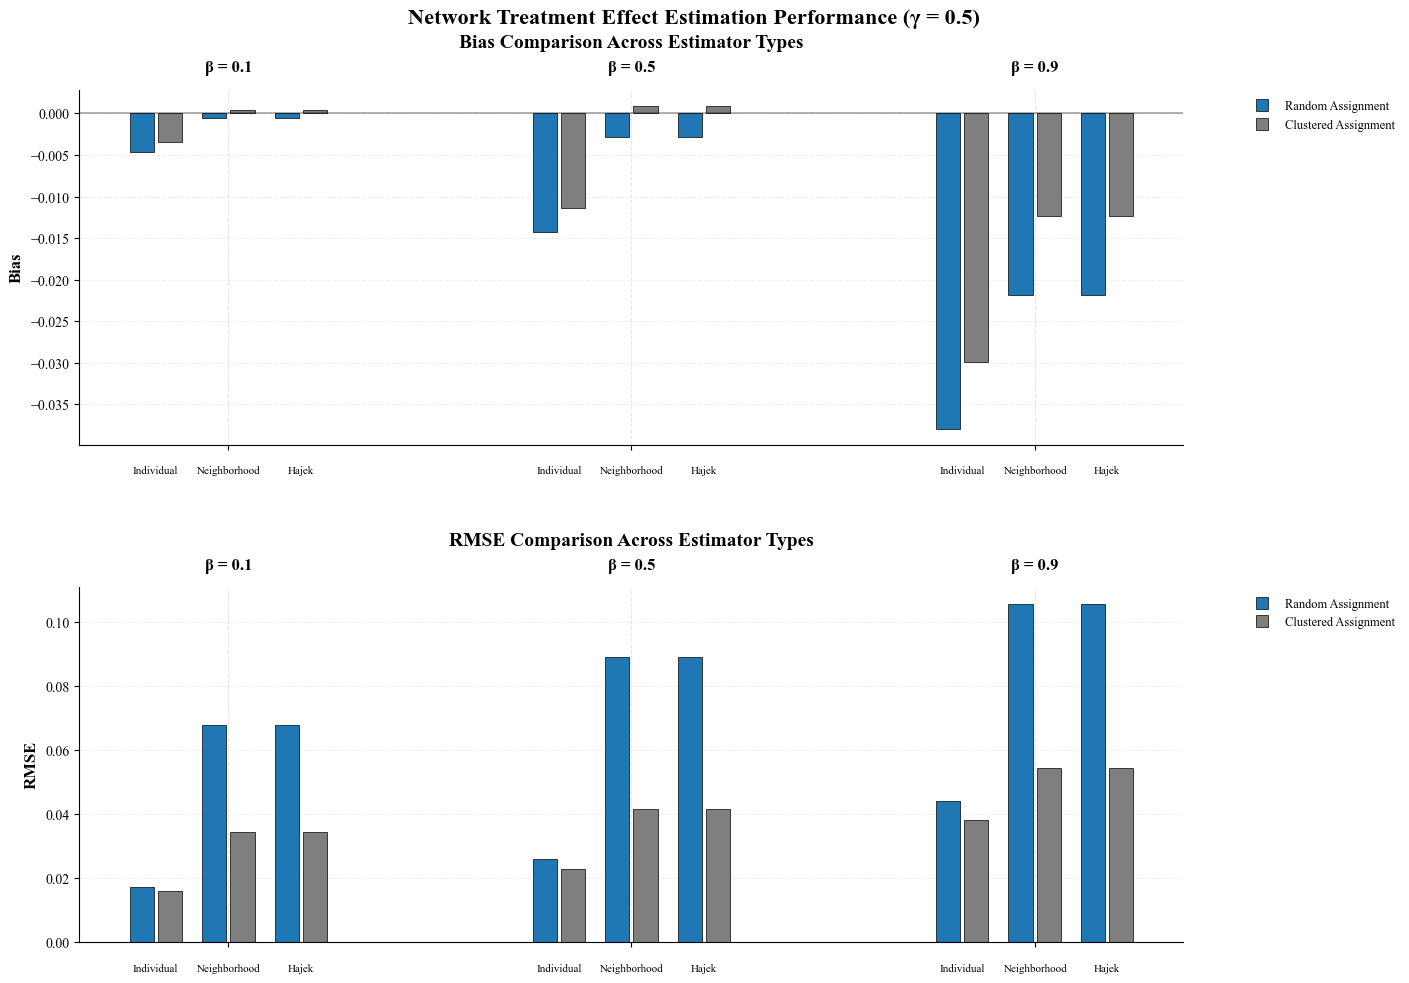

In [21]:
# Run simulations for multiple beta values (0.1, 0.5, 0.9) with gamma=0.5
beta_values = [0.1, 0.5, 0.9]
gamma_value = 0.5  # Changed to 0.5 as shown in the figure
T = 5
reps = 100  # Reduced for faster execution

# Store results and summaries
all_results = {}
all_summaries = {}

# Run simulations for each beta value
for beta in beta_values:
    print(f"\nRunning simulation for beta={beta}, gamma={gamma_value}")
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma_value,
        T=T,
        reps=reps
    )
    all_results[beta] = results
    all_summaries[beta] = summary

# Create plots - one for bias and one for RMSE
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Define estimators, labels, and colors
estimators = ['indiv', 'neigh', 'hajek']
est_labels = ['Individual', 'Neighborhood', 'Hajek']
assigns = ['rand', 'clust']
assign_labels = ['Random Assignment', 'Clustered Assignment']
colors = ['#1f77b4', '#7f7f7f']  # Professional blue/gray colors

# Adjust these parameters for better appearance
bar_width = 0.06  # Width of individual bars
bar_spacing = 0.01  # Space between adjacent bars (random vs clustered)
group_spacing = 0.06  # Space between estimator groups (indiv/neigh/hajek)
beta_spacing = 0.5  # Space between beta groups

# Calculate group positions centered on x ticks
x = np.arange(len(beta_values))
all_positions = []
group_centers = {}  # To store centers of each beta-estimator group for labels

for i, beta in enumerate(beta_values):
    for j, est in enumerate(estimators):
        # Calculate center position for this estimator within this beta group
        center_pos = x[i] + (j - 1) * (2*bar_width + group_spacing)
        group_centers[(beta, est)] = center_pos
        
        # Position for random assignment bar
        rand_pos = center_pos - bar_width/2 - bar_spacing/2
        all_positions.append((rand_pos, est, 'rand', beta))
        
        # Position for clustered assignment bar
        clust_pos = center_pos + bar_width/2 + bar_spacing/2
        all_positions.append((clust_pos, est, 'clust', beta))

# Prepare data for plotting
bias_data = []
rmse_data = []
x_pos_bias = []
x_pos_rmse = []
bar_colors = []

for pos, est, assign, beta in all_positions:
    summary = all_summaries[beta]
    bias_key = f"{est}_{assign}_t{T}_bias"
    rmse_key = f"{est}_{assign}_t{T}_rmse"
    
    # Choose color based on assignment type
    color = colors[0] if assign == 'rand' else colors[1]
    bar_colors.append(color)
    
    if bias_key in summary:
        bias_data.append(summary[bias_key])
        x_pos_bias.append(pos)
    
    if rmse_key in summary:
        rmse_data.append(summary[rmse_key])
        x_pos_rmse.append(pos)

# Plot bias (top plot)
ax = axes[0]

# Create bars for bias
bars_bias = ax.bar(x_pos_bias, bias_data, bar_width, color=bar_colors, 
                   edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('Bias', fontsize=12, fontweight='bold')
ax.set_title('Bias Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Add a zero line
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Create a custom legend and position it at the upper right, but outside the plot area
legend_elements = [
    Line2D([0], [0], color=colors[0], lw=0, marker='s', markersize=8, 
           label=assign_labels[0], markeredgecolor='black', markeredgewidth=0.5),
    Line2D([0], [0], color=colors[1], lw=0, marker='s', markersize=8, 
           label=assign_labels[1], markeredgecolor='black', markeredgewidth=0.5)
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, frameon=False)

# Plot RMSE (bottom plot)
ax = axes[1]

# Create bars for RMSE
bars_rmse = ax.bar(x_pos_rmse, rmse_data, bar_width, color=bar_colors, 
                    edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Add legend completely outside the plot area for the bottom plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, frameon=False)

# Adjust figure size to accommodate the legends
fig.tight_layout()
# Add extra space to the right of the plots for the legends
fig.subplots_adjust(top=0.90, hspace=0.4, right=0.85)

# Overall title with more space
plt.suptitle(f'Network Treatment Effect Estimation Performance (γ = {gamma_value})', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()


Running simulation for beta=0.1, gamma=0.9
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.5, gamma=0.9
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for beta=0.9, gamma=0.9
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...


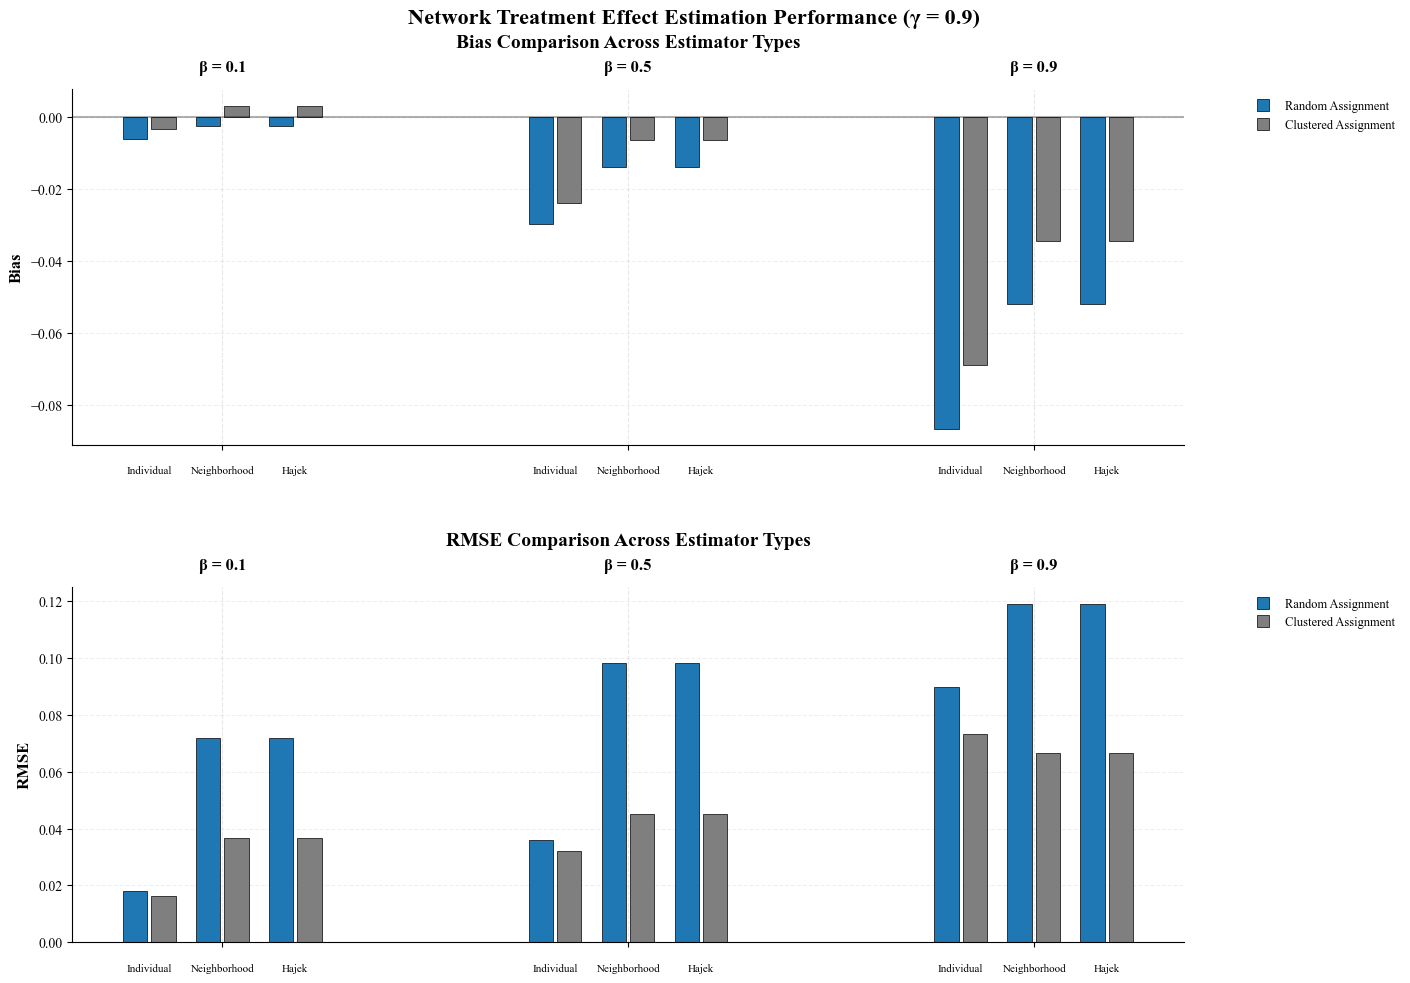

In [22]:
# Run simulations for multiple beta values (0.1, 0.5, 0.9) with gamma=0.5
beta_values = [0.1, 0.5, 0.9]
gamma_value = 0.9  # Changed to 0.5 as shown in the figure
T = 5
reps = 100  # Reduced for faster execution

# Store results and summaries
all_results = {}
all_summaries = {}

# Run simulations for each beta value
for beta in beta_values:
    print(f"\nRunning simulation for beta={beta}, gamma={gamma_value}")
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma_value,
        T=T,
        reps=reps
    )
    all_results[beta] = results
    all_summaries[beta] = summary

# Create plots - one for bias and one for RMSE
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Define estimators, labels, and colors
estimators = ['indiv', 'neigh', 'hajek']
est_labels = ['Individual', 'Neighborhood', 'Hajek']
assigns = ['rand', 'clust']
assign_labels = ['Random Assignment', 'Clustered Assignment']
colors = ['#1f77b4', '#7f7f7f']  # Professional blue/gray colors

# Adjust these parameters for better appearance
bar_width = 0.06  # Width of individual bars
bar_spacing = 0.01  # Space between adjacent bars (random vs clustered)
group_spacing = 0.06  # Space between estimator groups (indiv/neigh/hajek)
beta_spacing = 0.5  # Space between beta groups

# Calculate group positions centered on x ticks
x = np.arange(len(beta_values))
all_positions = []
group_centers = {}  # To store centers of each beta-estimator group for labels

for i, beta in enumerate(beta_values):
    for j, est in enumerate(estimators):
        # Calculate center position for this estimator within this beta group
        center_pos = x[i] + (j - 1) * (2*bar_width + group_spacing)
        group_centers[(beta, est)] = center_pos
        
        # Position for random assignment bar
        rand_pos = center_pos - bar_width/2 - bar_spacing/2
        all_positions.append((rand_pos, est, 'rand', beta))
        
        # Position for clustered assignment bar
        clust_pos = center_pos + bar_width/2 + bar_spacing/2
        all_positions.append((clust_pos, est, 'clust', beta))

# Prepare data for plotting
bias_data = []
rmse_data = []
x_pos_bias = []
x_pos_rmse = []
bar_colors = []

for pos, est, assign, beta in all_positions:
    summary = all_summaries[beta]
    bias_key = f"{est}_{assign}_t{T}_bias"
    rmse_key = f"{est}_{assign}_t{T}_rmse"
    
    # Choose color based on assignment type
    color = colors[0] if assign == 'rand' else colors[1]
    bar_colors.append(color)
    
    if bias_key in summary:
        bias_data.append(summary[bias_key])
        x_pos_bias.append(pos)
    
    if rmse_key in summary:
        rmse_data.append(summary[rmse_key])
        x_pos_rmse.append(pos)

# Plot bias (top plot)
ax = axes[0]

# Create bars for bias
bars_bias = ax.bar(x_pos_bias, bias_data, bar_width, color=bar_colors, 
                   edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('Bias', fontsize=12, fontweight='bold')
ax.set_title('Bias Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Add a zero line
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Create a custom legend and position it at the upper right, but outside the plot area
legend_elements = [
    Line2D([0], [0], color=colors[0], lw=0, marker='s', markersize=8, 
           label=assign_labels[0], markeredgecolor='black', markeredgewidth=0.5),
    Line2D([0], [0], color=colors[1], lw=0, marker='s', markersize=8, 
           label=assign_labels[1], markeredgecolor='black', markeredgewidth=0.5)
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, frameon=False)

# Plot RMSE (bottom plot)
ax = axes[1]

# Create bars for RMSE
bars_rmse = ax.bar(x_pos_rmse, rmse_data, bar_width, color=bar_colors, 
                    edgecolor='black', linewidth=0.5)

# Remove the frame on top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Style the plot
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison Across Estimator Types', fontsize=14, fontweight='bold', pad=30)
ax.set_xticks(x)
ax.set_xticklabels(['' for _ in beta_values])  # Empty labels for main axis
ax.set_axisbelow(True)  # Put gridlines behind data
ax.grid(axis='y', alpha=0.2)  # Very light grid

# Add beta labels at the top, properly centered over each beta group
for i, beta in enumerate(beta_values):
    ax.annotate(f'β = {beta}', 
                xy=(x[i], ax.get_ylim()[1]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

# Add estimator type labels centered below each group
for beta in beta_values:
    for j, est in enumerate(estimators):
        center = group_centers[(beta, est)]
        ax.annotate(est_labels[j], 
                    xy=(center, ax.get_ylim()[0]),
                    xytext=(0, -15),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=8)

# Add legend completely outside the plot area for the bottom plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, frameon=False)

# Adjust figure size to accommodate the legends
fig.tight_layout()
# Add extra space to the right of the plots for the legends
fig.subplots_adjust(top=0.90, hspace=0.4, right=0.85)

# Overall title with more space
plt.suptitle(f'Network Treatment Effect Estimation Performance (γ = {gamma_value})', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

## Extension 1 (Sensitivity to Diffusion)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.5
gamma = 0.5
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)



Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.5, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.014213,0.025836,-0.011324,0.022827,-0.002852,0.089049,0.000931,0.041671,-0.002852,0.089049,0.000931,0.041671
1,0.02,-0.012506,0.024189,-0.011297,0.022837,-0.005843,0.055980,-0.006472,0.038175,-0.005843,0.055980,-0.006472,0.038175
2,0.03,-0.010316,0.022826,-0.010868,0.023011,0.000990,0.058894,-0.005458,0.038292,0.000990,0.058894,-0.005458,0.038292
3,0.04,-0.009576,0.022170,-0.011019,0.021963,-0.005177,0.046598,-0.007106,0.036977,-0.005177,0.046598,-0.007106,0.036977
4,0.05,-0.013370,0.023408,-0.012743,0.023198,-0.010264,0.057237,-0.002662,0.045288,-0.010264,0.057237,-0.002662,0.045288
5,0.06,-0.010036,0.024316,-0.011639,0.022232,-0.007189,0.055312,-0.003426,0.047937,-0.007189,0.055312,-0.003426,0.047937
6,0.07,-0.008378,0.024149,-0.011302,0.023294,-0.022903,0.205217,-0.013309,0.061098,-0.022903,0.205217,-0.013309,0.061098
7,0.08,-0.009660,0.023082,-0.012245,0.026340,-0.007879,0.142933,-0.010815,0.087353,-0.007879,0.142933,-0.010815,0.087353
8,0.09,-0.010111,0.025616,-0.010379,0.021968,-0.032443,0.297833,-0.009746,0.082765,-0.032443,0.297833,-0.009746,0.082765
9,0.10,-0.006029,0.022499,-0.010479,0.022324,-0.019934,0.286852,-0.014770,0.147932,-0.019934,0.286852,-0.014770,0.147932


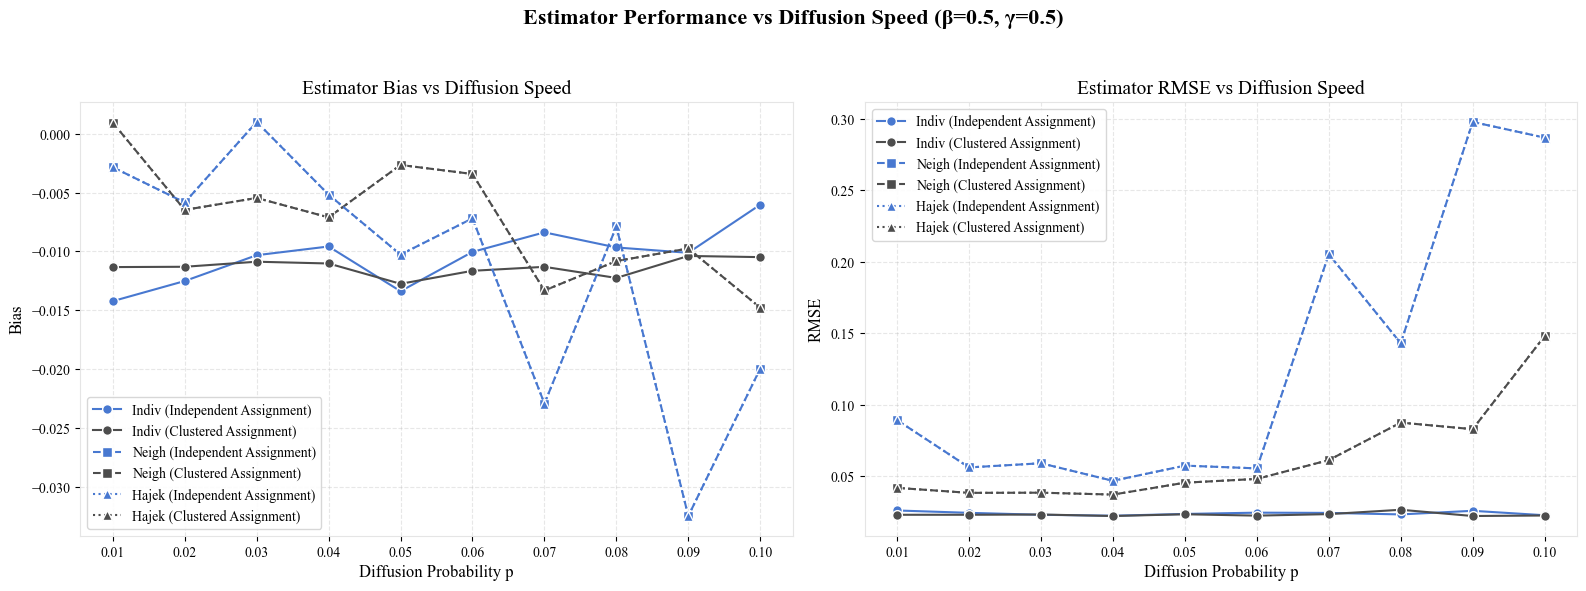

In [27]:
import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.1, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.002894,0.015727,-0.001985,0.015112,0.001387,0.067103,0.001187,0.033121,0.001387,0.067103,0.001187,0.033121
1,0.02,-0.001097,0.015924,-0.002773,0.014450,-0.000058,0.044360,-0.006431,0.029178,-0.000058,0.044360,-0.006431,0.029178
2,0.03,-0.000528,0.015488,-0.002322,0.014806,0.002182,0.050608,-0.004765,0.029268,0.002182,0.050608,-0.004765,0.029268
3,0.04,-0.001744,0.015590,-0.002499,0.015742,-0.001548,0.043215,-0.003569,0.030471,-0.001548,0.043215,-0.003569,0.030471
4,0.05,-0.002928,0.016064,-0.004538,0.015526,-0.005103,0.050404,0.000935,0.038019,-0.005103,0.050404,0.000935,0.038019
5,0.06,-0.000494,0.016945,-0.003128,0.015713,-0.001756,0.052574,-0.001866,0.041093,-0.001756,0.052574,-0.001866,0.041093
6,0.07,0.000805,0.018980,-0.002084,0.017249,-0.013116,0.196798,-0.008425,0.059403,-0.013116,0.196798,-0.008425,0.059403
7,0.08,-0.000810,0.018405,-0.003981,0.019991,-0.010548,0.142598,-0.005846,0.084077,-0.010548,0.142598,-0.005846,0.084077
8,0.09,-0.001311,0.019903,-0.003206,0.018168,-0.033495,0.299590,-0.006899,0.080878,-0.033495,0.299590,-0.006899,0.080878
9,0.10,0.001676,0.019869,-0.003220,0.017119,-0.023003,0.286764,-0.009071,0.135901,-0.023003,0.286764,-0.009071,0.135901


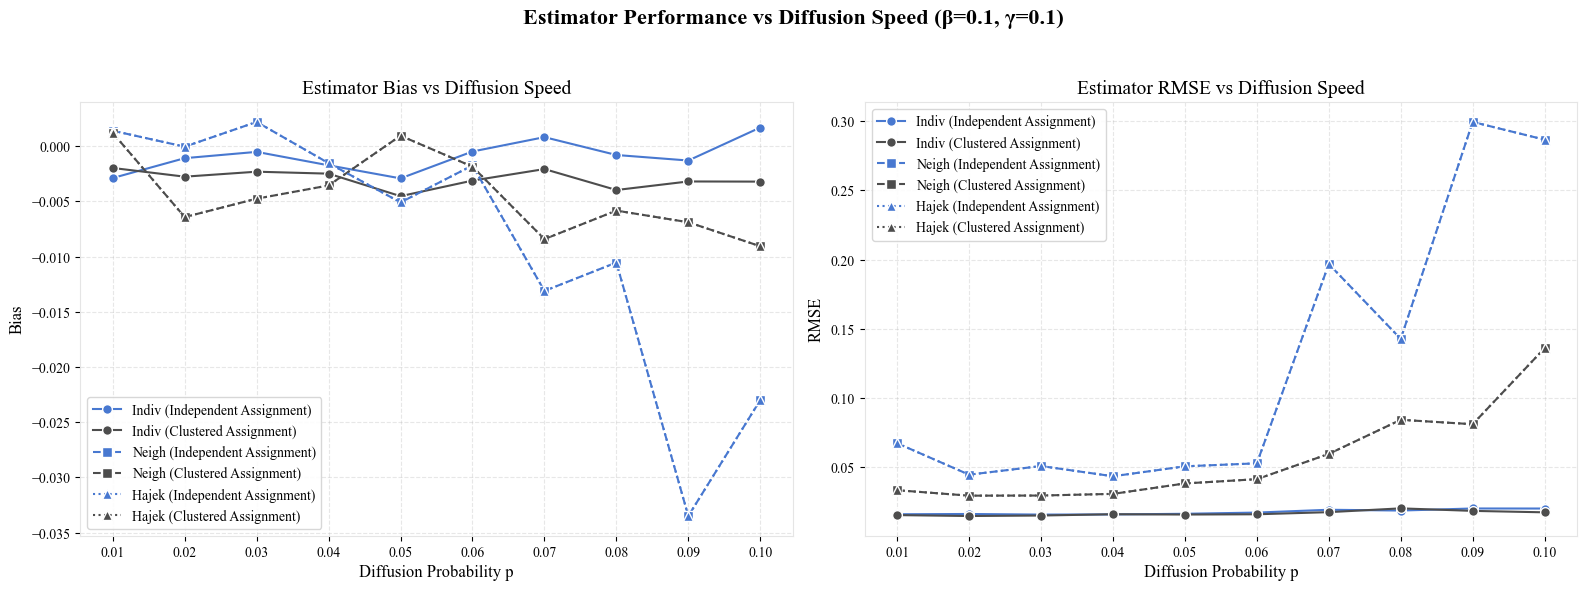

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.1
gamma = 0.1
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.5, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.004131,0.020477,-0.003349,0.018433,0.002760,0.085910,0.004317,0.040079,0.002760,0.085910,0.004317,0.040079
1,0.02,-0.002515,0.019564,-0.003750,0.018571,0.000201,0.052336,-0.003699,0.035420,0.000201,0.052336,-0.003699,0.035420
2,0.03,-0.001145,0.019912,-0.003334,0.019294,0.003501,0.058734,-0.002334,0.033851,0.003501,0.058734,-0.002334,0.033851
3,0.04,-0.001204,0.018928,-0.003483,0.018414,0.000210,0.046497,-0.001891,0.035240,0.000210,0.046497,-0.001891,0.035240
4,0.05,-0.004047,0.018265,-0.004863,0.018938,-0.006326,0.054605,0.002030,0.043567,-0.006326,0.054605,0.002030,0.043567
5,0.06,-0.001753,0.021265,-0.004330,0.018393,-0.002054,0.054685,0.001084,0.042643,-0.002054,0.054685,0.001084,0.042643
6,0.07,0.000011,0.022270,-0.003729,0.020227,-0.019617,0.201828,-0.008219,0.060905,-0.019617,0.201828,-0.008219,0.060905
7,0.08,-0.000859,0.020052,-0.005104,0.022558,-0.009770,0.143208,-0.005378,0.084286,-0.009770,0.143208,-0.005378,0.084286
8,0.09,-0.001778,0.022897,-0.004102,0.019298,-0.033575,0.297589,-0.006777,0.080000,-0.033575,0.297589,-0.006777,0.080000
9,0.10,0.000993,0.021119,-0.004102,0.019379,-0.021918,0.286478,-0.008101,0.136154,-0.021918,0.286478,-0.008101,0.136154


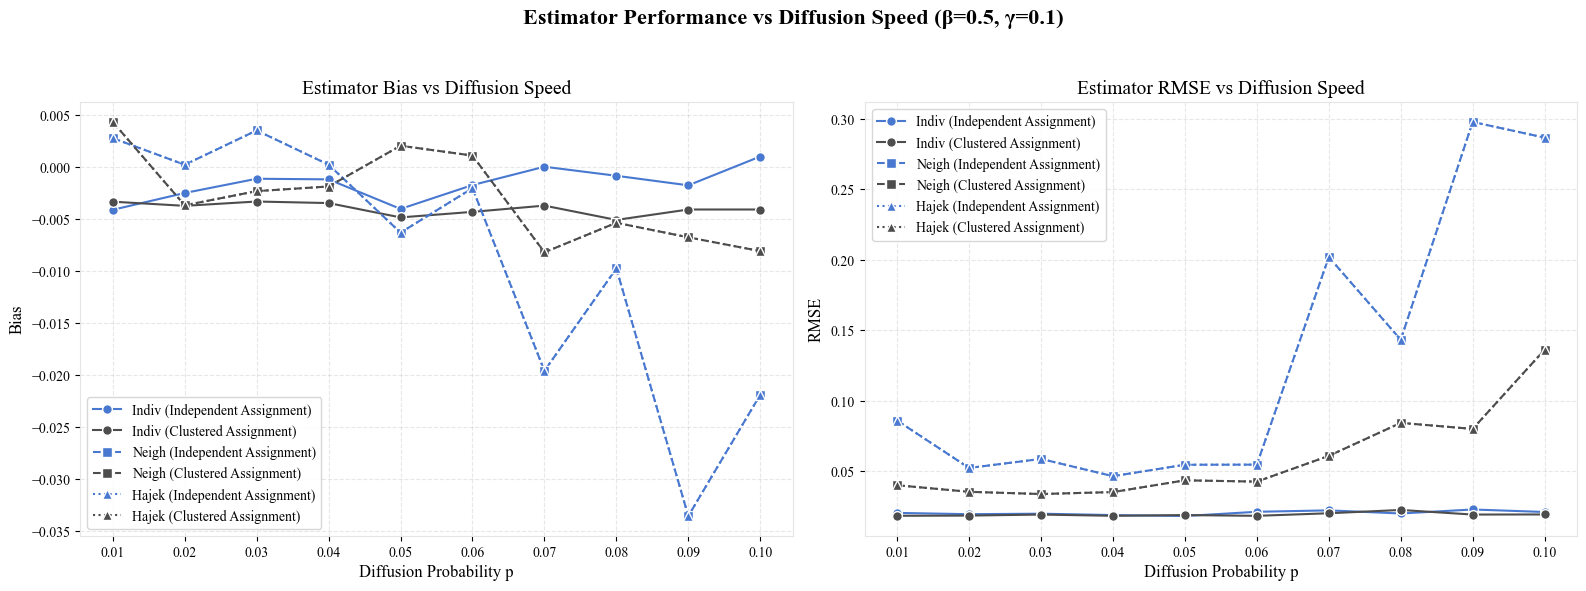

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.5
gamma = 0.1
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.9, gamma=0.1...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.007670,0.021795,-0.007736,0.023603,0.002043,0.096418,-0.001750,0.052247,0.002043,0.096418,-0.001750,0.052247
1,0.02,-0.006066,0.021337,-0.008949,0.023442,0.004910,0.061805,-0.006169,0.047674,0.004910,0.061805,-0.006169,0.047674
2,0.03,-0.004635,0.021420,-0.008828,0.023680,0.007177,0.064114,-0.004965,0.042141,0.007177,0.064114,-0.004965,0.042141
3,0.04,-0.004921,0.020888,-0.009005,0.023511,-0.002716,0.051394,-0.008090,0.045459,-0.002716,0.051394,-0.008090,0.045459
4,0.05,-0.006592,0.020989,-0.010263,0.023854,-0.005513,0.055915,-0.000587,0.051940,-0.005513,0.055915,-0.000587,0.051940
5,0.06,-0.005489,0.022098,-0.010034,0.021936,-0.004283,0.056198,-0.003771,0.048536,-0.004283,0.056198,-0.003771,0.048536
6,0.07,-0.004168,0.022823,-0.009260,0.024878,-0.021021,0.200952,-0.013055,0.063289,-0.021021,0.200952,-0.013055,0.063289
7,0.08,-0.004276,0.020704,-0.011889,0.027013,-0.011307,0.142849,-0.010605,0.087340,-0.011307,0.142849,-0.010605,0.087340
8,0.09,-0.006311,0.023749,-0.010632,0.023046,-0.035875,0.298997,-0.011740,0.083702,-0.035875,0.298997,-0.011740,0.083702
9,0.10,-0.003337,0.021185,-0.010947,0.022185,-0.024981,0.288638,-0.013807,0.138894,-0.024981,0.288638,-0.013807,0.138894


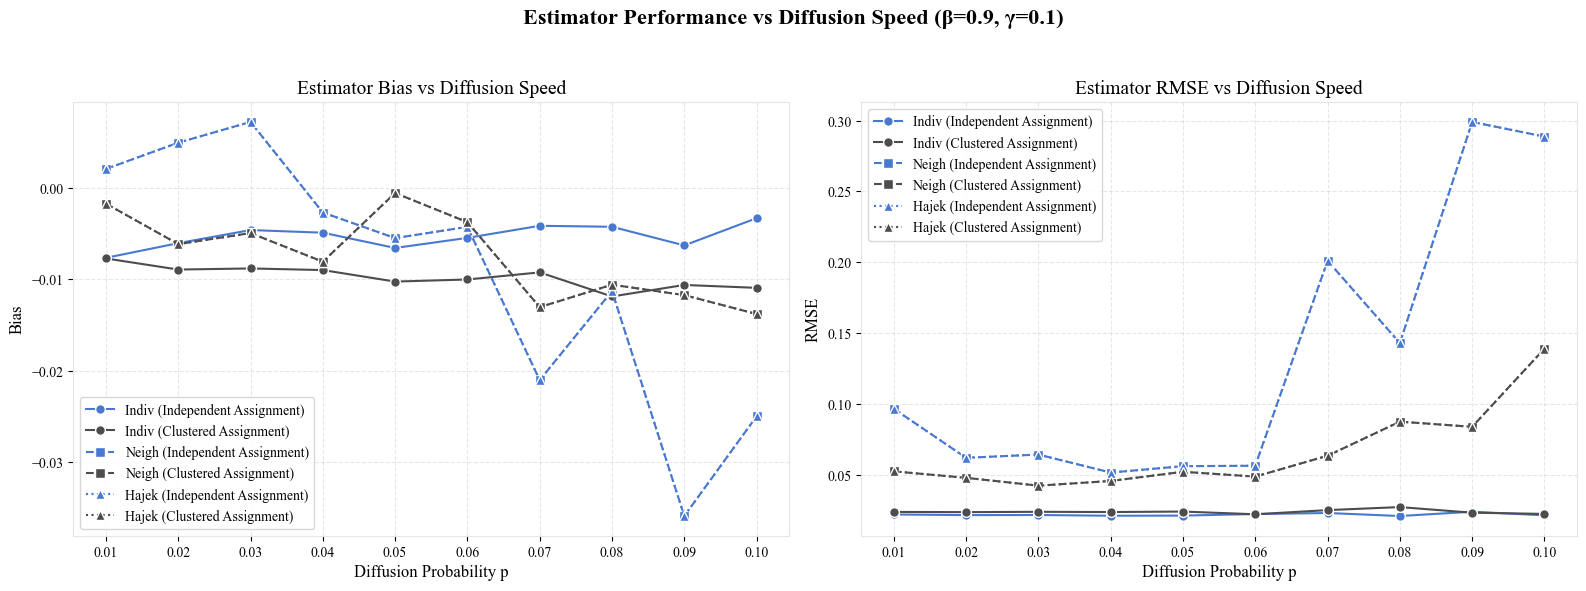

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.9
gamma = 0.1
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.5, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.029605,0.035995,-0.023866,0.032023,-0.013883,0.098458,-0.006406,0.045161,-0.013883,0.098458,-0.006406,0.045161
1,0.02,-0.027338,0.034217,-0.024349,0.032010,-0.014592,0.061862,-0.015845,0.044058,-0.014592,0.061862,-0.015845,0.044058
2,0.03,-0.025557,0.031784,-0.023948,0.032508,-0.007369,0.057482,-0.015320,0.042757,-0.007369,0.057482,-0.015320,0.042757
3,0.04,-0.024177,0.030802,-0.023253,0.030676,-0.017051,0.052334,-0.015609,0.040441,-0.017051,0.052334,-0.015609,0.040441
4,0.05,-0.027742,0.034069,-0.025437,0.032779,-0.020220,0.061229,-0.012313,0.048059,-0.020220,0.061229,-0.012313,0.048059
5,0.06,-0.024043,0.032780,-0.024670,0.031587,-0.017754,0.061359,-0.012467,0.051088,-0.017754,0.061359,-0.012467,0.051088
6,0.07,-0.022955,0.033235,-0.024145,0.032605,-0.033734,0.212675,-0.019962,0.066460,-0.033734,0.212675,-0.019962,0.066460
7,0.08,-0.022724,0.031609,-0.024028,0.033608,-0.013094,0.145679,-0.021719,0.094814,-0.013094,0.145679,-0.021719,0.094814
8,0.09,-0.023653,0.034703,-0.022049,0.030996,-0.052717,0.324776,-0.021001,0.087880,-0.052717,0.324776,-0.021001,0.087880
9,0.10,-0.020218,0.030237,-0.023013,0.030969,-0.030849,0.301237,-0.018149,0.149261,-0.030849,0.301237,-0.018149,0.149261


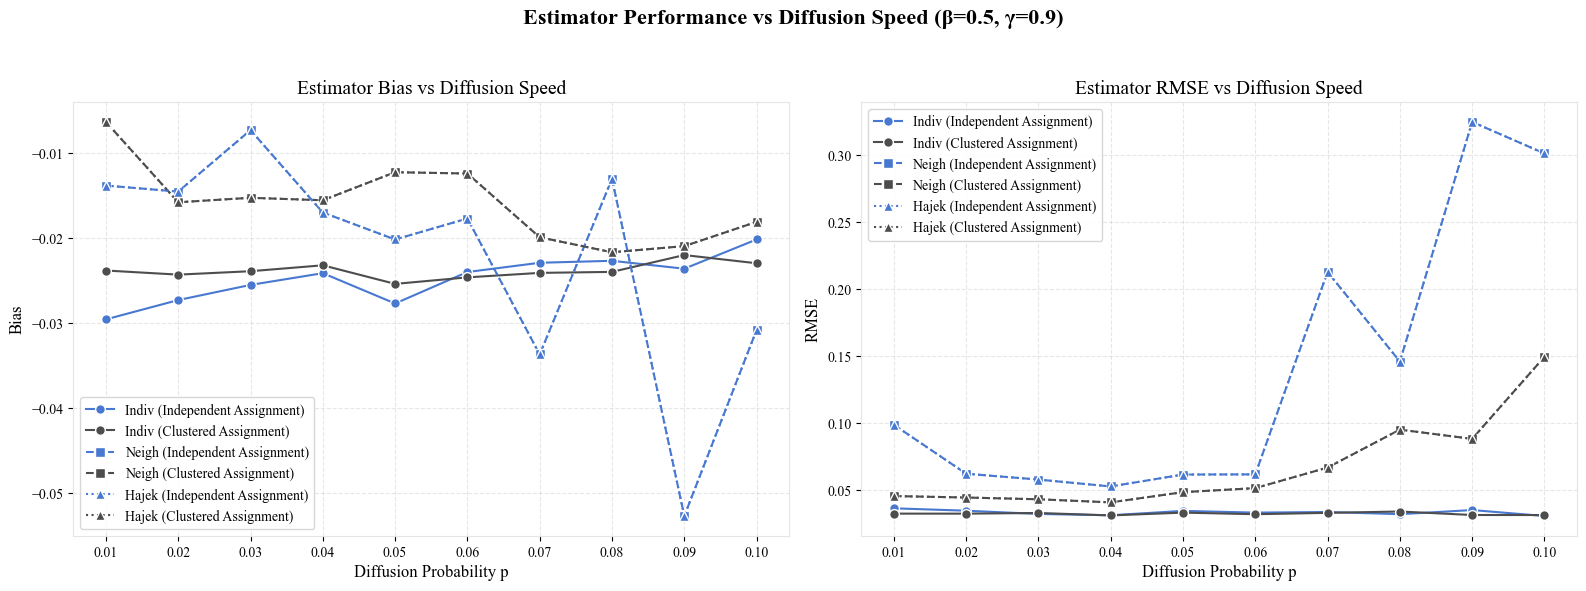

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.5
gamma = 0.9
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.1, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.004603,0.017125,-0.003406,0.015908,-0.000541,0.067760,0.000399,0.034267,-0.000541,0.067760,0.000399,0.034267
1,0.02,-0.002535,0.016458,-0.004190,0.015489,-0.000736,0.044281,-0.007771,0.031125,-0.000736,0.044281,-0.007771,0.031125
2,0.03,-0.001920,0.015865,-0.003646,0.016081,0.001471,0.052286,-0.005398,0.031161,0.001471,0.052286,-0.005398,0.031161
3,0.04,-0.003176,0.016382,-0.003654,0.016415,-0.002723,0.042478,-0.004682,0.030390,-0.002723,0.042478,-0.004682,0.030390
4,0.05,-0.004590,0.017396,-0.006246,0.016527,-0.005412,0.051021,0.000069,0.038464,-0.005412,0.051021,0.000069,0.038464
5,0.06,-0.001871,0.017635,-0.004590,0.016228,-0.002789,0.054013,-0.003378,0.045252,-0.002789,0.054013,-0.003378,0.045252
6,0.07,-0.000903,0.019614,-0.003751,0.017752,-0.014417,0.201492,-0.011594,0.060390,-0.014417,0.201492,-0.011594,0.060390
7,0.08,-0.002979,0.019963,-0.005748,0.020729,-0.006762,0.142437,-0.008740,0.087200,-0.006762,0.142437,-0.008740,0.087200
8,0.09,-0.002818,0.020454,-0.004376,0.018367,-0.030021,0.299163,-0.008032,0.083000,-0.030021,0.299163,-0.008032,0.083000
9,0.10,0.000517,0.020423,-0.004242,0.017430,-0.019408,0.286683,-0.013148,0.147726,-0.019408,0.286683,-0.013148,0.147726


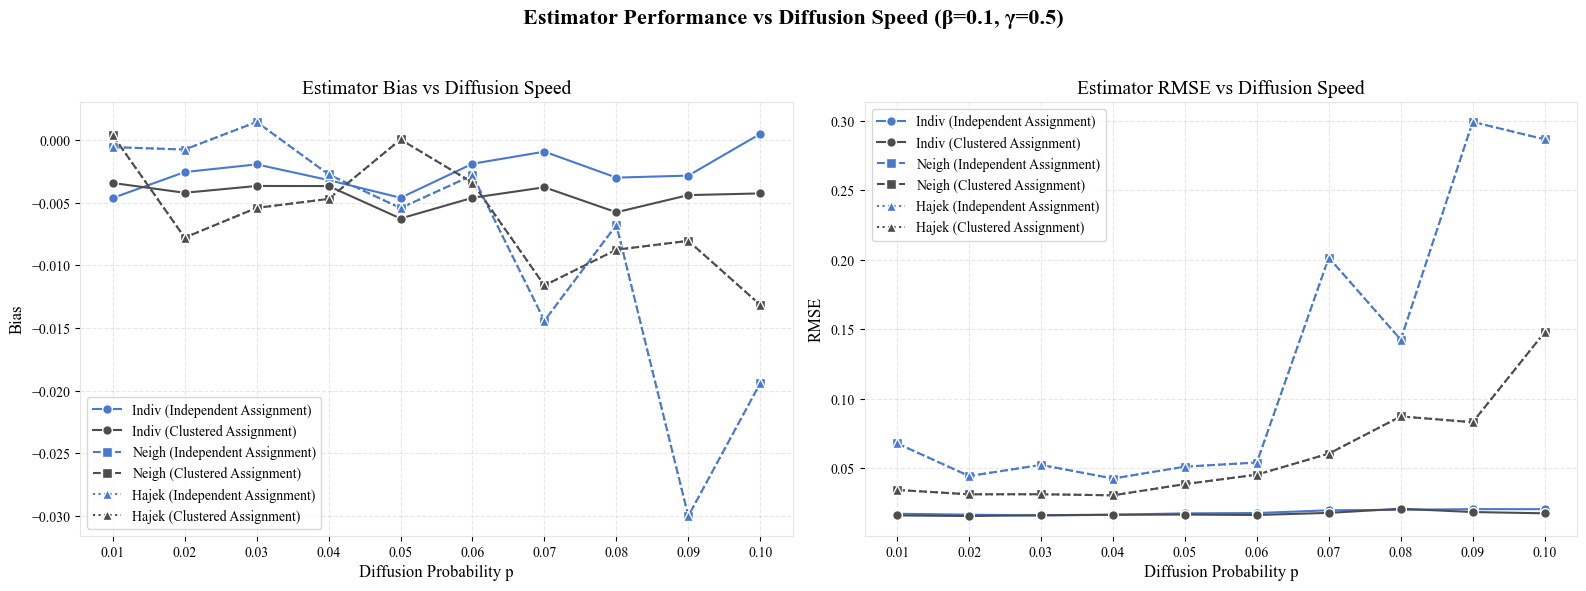

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.1
gamma = 0.5
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.1, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.006132,0.018124,-0.003275,0.016272,-0.002333,0.071841,0.003219,0.036669,-0.002333,0.071841,0.003219,0.036669
1,0.02,-0.004146,0.017530,-0.003677,0.016582,-0.002776,0.047650,-0.006139,0.032296,-0.002776,0.047650,-0.006139,0.032296
2,0.03,-0.003689,0.016782,-0.003161,0.016331,0.002170,0.052736,-0.004256,0.031895,0.002170,0.052736,-0.004256,0.031895
3,0.04,-0.004304,0.017367,-0.003184,0.016706,-0.004561,0.046462,-0.003834,0.031936,-0.004561,0.046462,-0.003834,0.031936
4,0.05,-0.006333,0.018340,-0.005809,0.016871,-0.007715,0.053582,-0.000386,0.040656,-0.007715,0.053582,-0.000386,0.040656
5,0.06,-0.003389,0.018493,-0.004304,0.017253,-0.004732,0.058558,-0.002183,0.047168,-0.004732,0.058558,-0.002183,0.047168
6,0.07,-0.002294,0.020317,-0.003764,0.018432,-0.024459,0.213222,-0.010382,0.064337,-0.024459,0.213222,-0.010382,0.064337
7,0.08,-0.004012,0.020850,-0.004995,0.020868,-0.004044,0.143102,-0.011421,0.092861,-0.004044,0.143102,-0.011421,0.092861
8,0.09,-0.003988,0.021311,-0.003980,0.018801,-0.044874,0.326121,-0.009034,0.085991,-0.044874,0.326121,-0.009034,0.085991
9,0.10,-0.000719,0.021316,-0.004042,0.017798,-0.014490,0.286135,-0.010132,0.148292,-0.014490,0.286135,-0.010132,0.148292


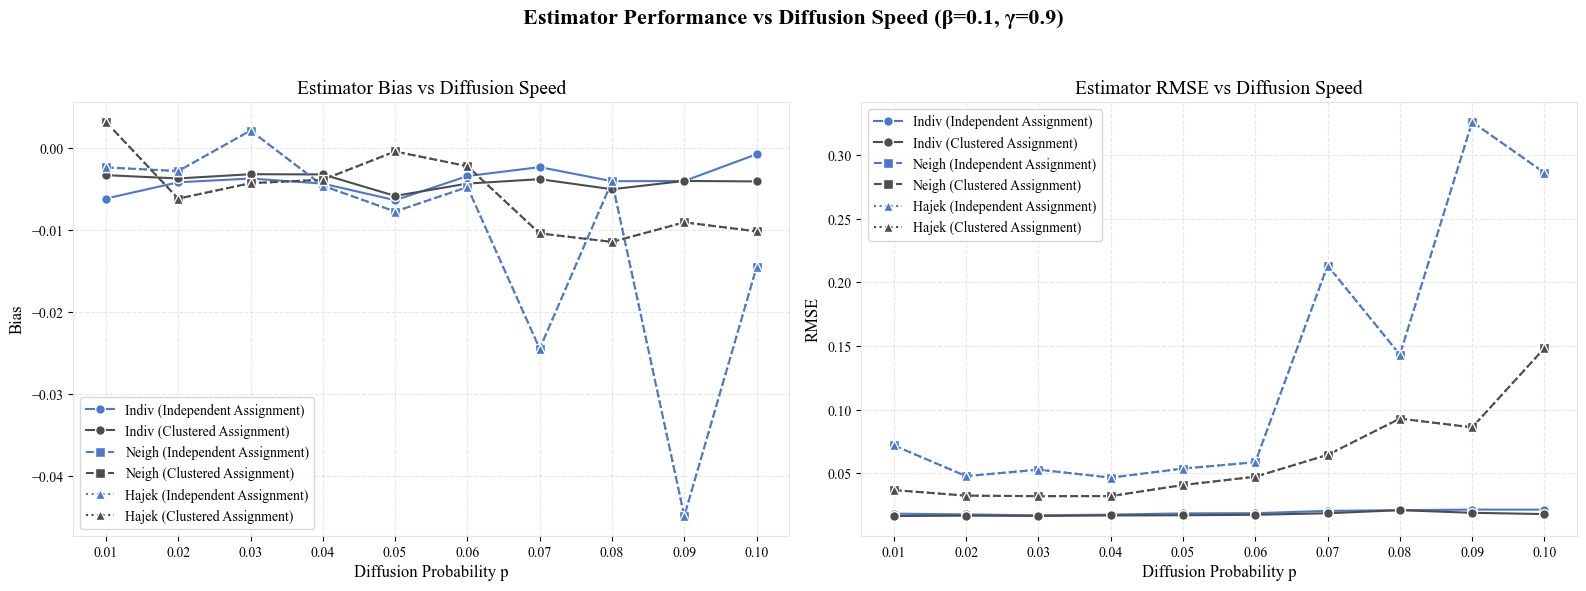

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.1
gamma = 0.9
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.9, gamma=0.5...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.037905,0.043921,-0.029892,0.038042,-0.021811,0.105562,-0.012380,0.054282,-0.021811,0.105562,-0.012380,0.054282
1,0.02,-0.034294,0.040476,-0.030169,0.037983,-0.010729,0.066151,-0.016083,0.053246,-0.010729,0.066151,-0.016083,0.053246
2,0.03,-0.031677,0.038100,-0.030669,0.038174,-0.004756,0.065904,-0.014648,0.046025,-0.004756,0.065904,-0.014648,0.046025
3,0.04,-0.030420,0.036926,-0.029597,0.036796,-0.016777,0.052032,-0.019935,0.048354,-0.016777,0.052032,-0.019935,0.048354
4,0.05,-0.031541,0.038062,-0.031080,0.038089,-0.020942,0.062329,-0.010184,0.053431,-0.020942,0.062329,-0.010184,0.053431
5,0.06,-0.028464,0.036101,-0.029813,0.036771,-0.018826,0.059969,-0.014579,0.053702,-0.018826,0.059969,-0.014579,0.053702
6,0.07,-0.028149,0.036388,-0.029518,0.037751,-0.032859,0.207685,-0.022718,0.066488,-0.032859,0.207685,-0.022718,0.066488
7,0.08,-0.027218,0.035611,-0.031041,0.040203,-0.016736,0.144422,-0.022998,0.092100,-0.016736,0.144422,-0.022998,0.092100
8,0.09,-0.027538,0.036497,-0.029749,0.037079,-0.039973,0.299520,-0.022236,0.087259,-0.039973,0.299520,-0.022236,0.087259
9,0.10,-0.023334,0.032923,-0.030310,0.036808,-0.028745,0.290903,-0.028419,0.152923,-0.028745,0.290903,-0.028419,0.152923


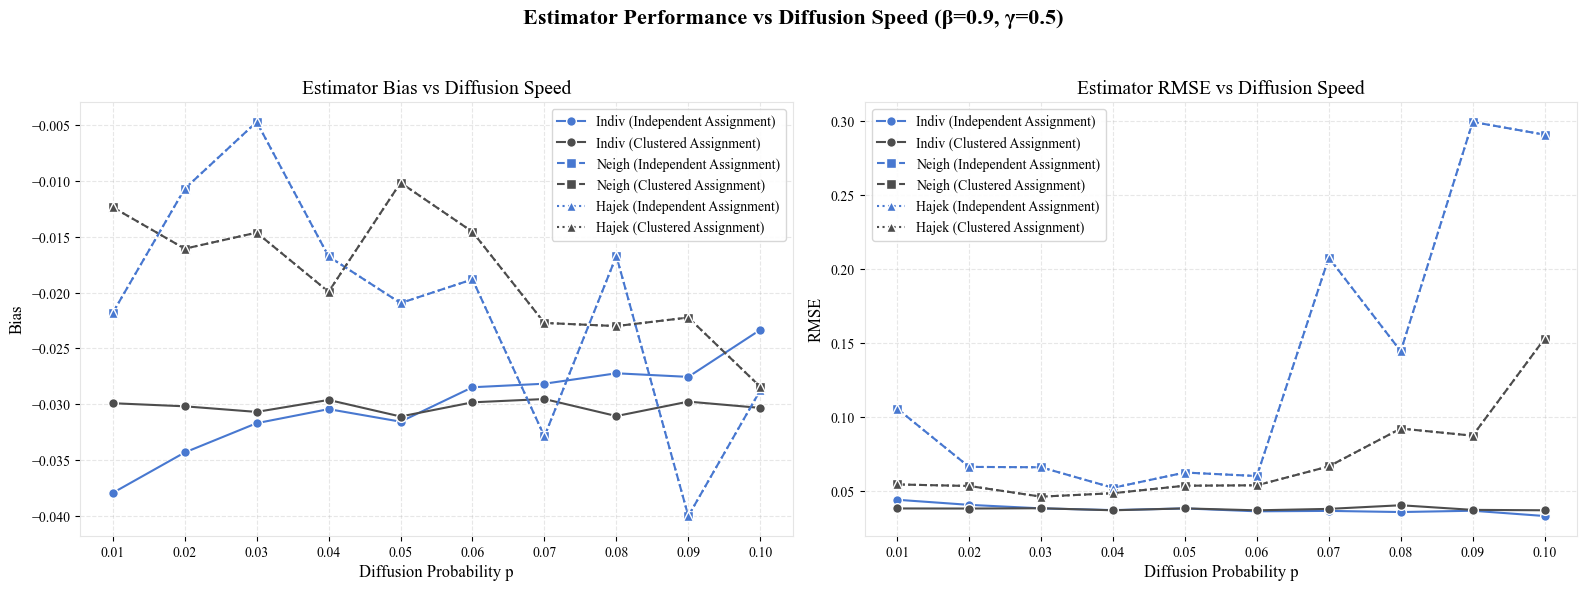

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.9
gamma = 0.5
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Running simulation for diffusion probability p=0.01...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.02...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.03...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.04...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.05...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diffusion probability p=0.06...
Simulating true ATE with beta=0.9, gamma=0.9...
Starting replication 0...
Computing summary statistics...

Running simulation for diff

,p,indiv_rand_bias,indiv_rand_rmse,indiv_clust_bias,indiv_clust_rmse,neigh_rand_bias,neigh_rand_rmse,neigh_clust_bias,neigh_clust_rmse,hajek_rand_bias,hajek_rand_rmse,hajek_clust_bias,hajek_clust_rmse
0,0.01,-0.086559,0.089702,-0.068887,0.073464,-0.051778,0.119133,-0.034461,0.066620,-0.051778,0.119133,-0.034461,0.066620
1,0.02,-0.080633,0.083588,-0.070127,0.074187,-0.044820,0.081221,-0.040012,0.068698,-0.044820,0.081221,-0.040012,0.068698
2,0.03,-0.078051,0.080865,-0.069136,0.073271,-0.033789,0.076646,-0.038634,0.060946,-0.033789,0.076646,-0.038634,0.060946
3,0.04,-0.073990,0.076808,-0.067306,0.071134,-0.046030,0.069829,-0.042033,0.060625,-0.046030,0.069829,-0.042033,0.060625
4,0.05,-0.073693,0.077303,-0.070896,0.074830,-0.049188,0.078483,-0.036442,0.064868,-0.049188,0.078483,-0.036442,0.064868
5,0.06,-0.070602,0.074103,-0.067727,0.071357,-0.048665,0.079208,-0.037762,0.065715,-0.048665,0.079208,-0.037762,0.065715
6,0.07,-0.068786,0.073166,-0.067220,0.071352,-0.062470,0.224526,-0.044320,0.080675,-0.062470,0.224526,-0.044320,0.080675
7,0.08,-0.066179,0.070660,-0.064642,0.070019,-0.038189,0.155269,-0.045226,0.106542,-0.038189,0.155269,-0.045226,0.106542
8,0.09,-0.067934,0.073339,-0.063397,0.067971,-0.074068,0.329489,-0.047407,0.100971,-0.074068,0.329489,-0.047407,0.100971
9,0.10,-0.061637,0.066886,-0.064706,0.068693,-0.061518,0.322430,-0.048505,0.159066,-0.061518,0.322430,-0.048505,0.159066


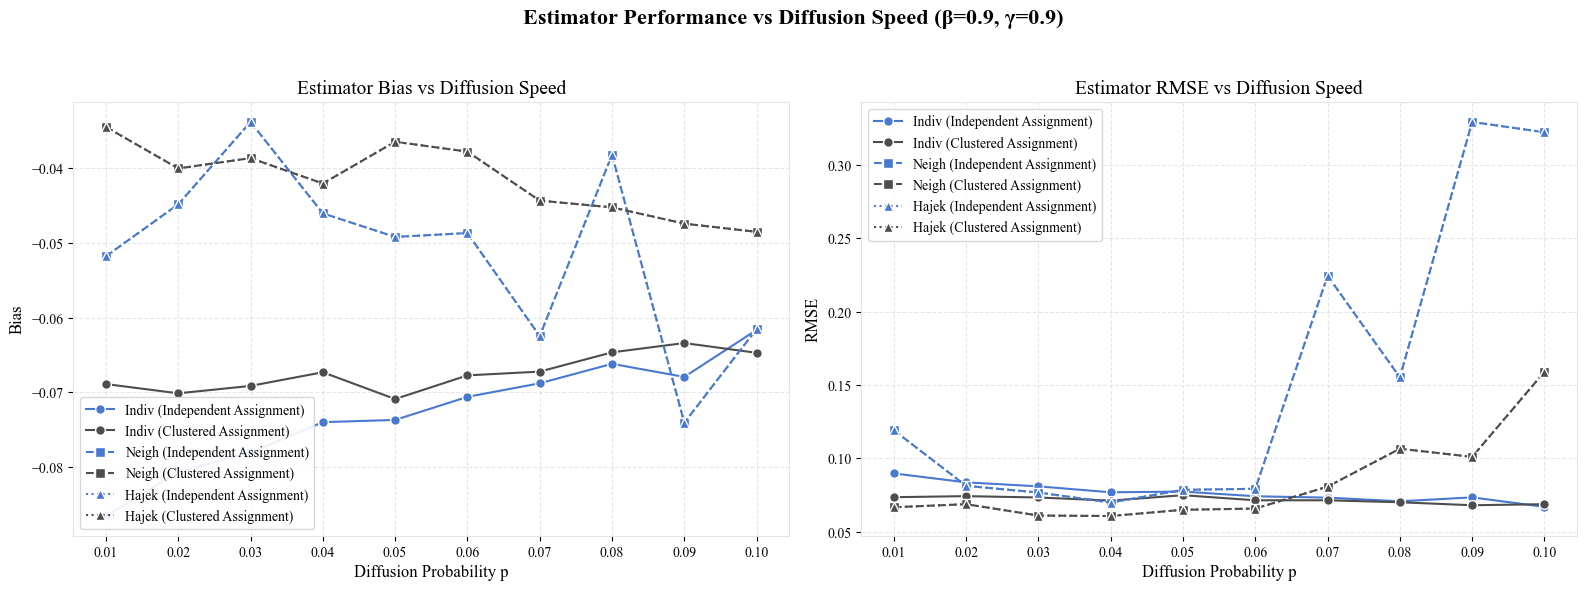

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined:
# G, initial_treatments (random_treatment and clustered_treatment)
# simulate_multiple_diffusions
# run_simulation
# (i.e., everything you already have!)

# Simulation parameters
T = 5  # number of diffusion steps
beta = 0.9
gamma = 0.9
reps = 100
alpha = -1.5
diffusion_model = 'ICM'

# Define diffusion speeds to test
diffusion_ps = np.arange(0.01, 0.11, 0.01)  # p = 0.01, ..., 0.09, 0.1

# Container for results
final_results = []

# Main simulation loop
for p in diffusion_ps:
    print(f"\nRunning simulation for diffusion probability p={p:.2f}...")
    
    # 1. Simulate diffusion
    histories = simulate_multiple_diffusions(G, initial_treatments, T=T, diffusion_model=diffusion_model, p=p)
    
    # 2. Run simulation
    results, summary = run_simulation(
        G=G,
        histories=histories,
        beta=beta,
        gamma=gamma,
        reps=reps,
        T=T,
        alpha=alpha
    )
    
    # 3. Record last time step (t=5) bias and RMSE
    record = {'p': p}
    for estimator in ["indiv", "neigh", "hajek"]:
        for assign in ["rand", "clust"]:
            bias_key = f"{estimator}_{assign}_t{T}_bias"
            rmse_key = f"{estimator}_{assign}_t{T}_rmse"
            record[f"{estimator}_{assign}_bias"] = summary.get(bias_key, np.nan)
            record[f"{estimator}_{assign}_rmse"] = summary.get(rmse_key, np.nan)
    
    final_results.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(final_results)

# Display the final summary table
print("\nSummary Table (Bias and RMSE at T=5):")
display(results_df)


import matplotlib.pyplot as plt

# --- Academic-Styled Plot: Bias and RMSE vs Diffusion Speed (w/ Hajek) ---

# 1. Define styles: color by assignment, line style & marker by estimator
colors = {
    'rand': '#4878D0',   # blue for random
    'clust': '#4D4D4D'   # dark gray for clustered
}
styles = {
    'indiv': {'linestyle': '-',  'marker': 'o'},
    'neigh': {'linestyle': '--', 'marker': 's'},
    'hajek': {'linestyle': ':',  'marker': '^'}
}
assign_labels = {
    'rand': 'Independent Assignment',
    'clust': 'Clustered Assignment'
}

# 2. Set academic font + grid styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# 3. Plot Bias and RMSE (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Include all 3 estimators now
plot_estimators = ['indiv', 'neigh', 'hajek']
assignments = ['rand', 'clust']

# --- Bias Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax1.plot(
            results_df['p'],
            results_df[f"{label}_bias"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax1.set_title("Estimator Bias vs Diffusion Speed", fontsize=14)
ax1.set_xlabel("Diffusion Probability p", fontsize=12)
ax1.set_ylabel("Bias", fontsize=12)
ax1.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax1.set_xticks(results_df['p'])

# --- RMSE Plot ---
for estimator in plot_estimators:
    for assign in assignments:
        label = f"{estimator}_{assign}"
        ax2.plot(
            results_df['p'],
            results_df[f"{label}_rmse"],
            label=f"{estimator.capitalize()} ({assign_labels[assign]})",
            color=colors[assign],
            linestyle=styles[estimator]['linestyle'],
            marker=styles[estimator]['marker'],
            markersize=7,
            linewidth=1.5,
            markeredgewidth=1,
            markeredgecolor='white'
        )

ax2.set_title("Estimator RMSE vs Diffusion Speed", fontsize=14)
ax2.set_xlabel("Diffusion Probability p", fontsize=12)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.legend(loc="best", frameon=True, framealpha=0.9, edgecolor='lightgray')
ax2.set_xticks(results_df['p'])

# 4. Add consistent light gray borders
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#E5E5E5')

# 5. Main title
fig.suptitle(f"Estimator Performance vs Diffusion Speed (β={beta}, γ={gamma})", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()